In [1]:
# !pip install qiskit

In [115]:
import math
import random

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal, Categorical

from qiskit.quantum_info import random_state
import csv

In [116]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [117]:
use_cuda = torch.cuda.is_available()
device   = torch.device("cuda" if use_cuda else "cpu")

In [118]:
def bit_flip_Y(x):
    matrix = np.array([[0, -1j],[1j,0]])
    x = np.squeeze(x)
    probs = np.matmul(matrix,x)
#     prob_1 = probs[0]
#     prob_2 = probs[1]
#     return prob_1, prob_2
    return probs

def measurement(x,y):
    p1 = abs(x)**2
    p2 = abs(y)**2
    diff = 1 - (p1+p2)
    p1 = p1+diff
    bit =  np.random.choice(2, 1, p=[p1,p2])
    if bit==1:
        state = np.array([0+0j,1+0j])
    elif bit==0:
        state = np.array([1+0j,0+0j])
    return state

def bit_flip_X(x):
    matrix = np.array([[0, 1],[1,0]])
    x = np.squeeze(x)
    probs = np.matmul(matrix,x)
#     prob_1 = probs[0]
#     prob_2 = probs[1]
#     return prob_1, prob_2
    return probs

def hadamard_X(x):
    matrix = np.array([[1, 1],[1,-1]])
    x = np.squeeze(x)
    matrix = matrix/math.sqrt(2)
#     state = np.array([x,y])
    probs = np.matmul(matrix,x)
#     prob_1 = probs[0]
#     prob_2 = probs[1]
#     return prob_1, prob_2
    return probs

def hadamard_Y(x):
    matrix = np.array([[1, -1j],[1j,-1]])
    x = np.squeeze(x)
    matrix = matrix/math.sqrt(2)
#     state = np.array([x,y])
    probs = np.matmul(matrix,x)
#     prob_1 = probs[0]
#     prob_2 = probs[1]
#     return prob_1, prob_2
    return probs

def nothing(x):
    return x


def reward(state, final_state):
    if np.allclose(state,final_state):
        reward = 1
    else:
        reward = 0
#    elif(error_t<error_t1):
#        reward = -1
    return reward

In [119]:
class Environment:

    def reset(self):
        state = random_state(2)
        state_abs, new_state = state_norm(state)
#        new_state = np.reshape(new_state.flatten(), (1,1,2))
        return state_abs, new_state

In [120]:
def state_norm(state):
    norm = 0.
    for i in range(state.shape[0]):
        norm += abs(state[i])**2
    norm = math.sqrt(norm)
    state = state/(norm)
    state_abs = np.array([abs(state[0]), abs(state[1])])
    return state_abs, state

In [121]:
def projection(state, final_state):
#     e = (abs(state)**2 - abs(final_state)**2)
    e = np.dot(state,final_state)
    e = abs(e)
    e = e**2
    e = np.float32(np.squeeze(e))
    return np.array([e])

In [122]:
def plot(frame_idx, rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, rewards[-1]))
    plt.plot(rewards)
    plt.show()
    
def test_env(vis=False):
    count=0
    env = Environment()
#     print("entered the tes_env")
    state_abs, new_state = env.reset()
    proj = projection(new_state, final_state)
#     if vis: env.render()
    done = False
    total_reward = 0
#     print("Initial Done state: ", done)
    while not done:
        count+=1
        print(count)
        state = torch.FloatTensor(proj).unsqueeze(0).to(device)
        dist, _ = model(state)
        new_state = eval(command[dist.sample()])
#         state = new_state
        rw = reward(new_state, final_state)
        if(np.allclose(new_state,final_state)):
            done = True
#         if vis: env.render()
        total_reward += rw
    return total_reward

In [163]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0., std=0.1)
        nn.init.constant_(m.bias, 0.1)
        

class ActorCritic(nn.Module):
    def __init__(self, num_inputs, num_outputs, hidden_size, std=0.0):
        super(ActorCritic, self).__init__()
        
        self.critic = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
        
        self.actor = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_outputs),
        )
        self.log_std = nn.Parameter(torch.ones(1, num_outputs) * std)
        
        self.apply(init_weights)
        
    def forward(self, x):

        value = self.critic(x)
        mu    = F.softmax(self.actor(x))
        if(mu.shape[0]==len(command)):
            mu    = mu.reshape(1,mu.shape[0])
        dist  = Categorical(mu)
        return dist, value

In [164]:
def compute_gae(next_value, rewards, masks, values, gamma=0.99, tau=0.95):
#     print("In the function!!!!!!!!")
    values = values + [next_value]
#     print("rewards: ", rewards)
#     print("values: ", values)
#     print("masks: ", masks)
    gae = 0
    returns = []
    for step in reversed(range(len(rewards))):
        delta = rewards[step] + gamma * values[step + 1] * masks[step] - values[step]
#         print("delta: ", delta)
        gae = delta + gamma * tau * masks[step] * gae
        
        returns.append(gae + values[step])
#     print(returns)
    return returns


In [165]:
def ppo_iter(mini_batch_size, states, actions, log_probs, returns, advantage):
#     print(states.size(0))
    batch_size = states.size(0)
    for _ in range(batch_size // mini_batch_size):
        rand_ids = np.random.randint(0, batch_size, mini_batch_size)
#         print("random IDs: ",rand_ids)
        for i in range(len(rand_ids)):
#             print("STATES: ", states.shape)
#             print("actions: ", actions.shape)
#             print("PROBS: ", log_probs.shape)
#             print("RETURN: ", returns.shape)
#             print("ADV: ", advantage.shape)
            
            yield states[rand_ids], actions[rand_ids], log_probs[rand_ids], returns[rand_ids, :], advantage[rand_ids, :]
        
        

def ppo_update(ppo_epochs, mini_batch_size, states, actions, log_probs, returns, advantages, clip_param=0.2):
    for _ in range(ppo_epochs):
        for state, action, old_log_probs, return_, advantage in ppo_iter(mini_batch_size, states, actions, log_probs, returns, advantages):
#             print("STATE SIZE IN PPO UPDATE: ", state.shape)
            state = state.reshape(1,state.shape[0])
            state = torch.transpose(state, 0, 1)
#             print("STATE SIZE IN PPO UPDATE (TRANSPOSE): ", state)
#             print(model)
            dist, value = model(state)
            entropy = dist.entropy().mean()
            new_log_probs = dist.log_prob(action)

            ratio = (new_log_probs - old_log_probs).exp()
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1.0 - clip_param, 1.0 + clip_param) * advantage

            actor_loss  = - torch.min(surr1, surr2).mean()
            critic_loss = (return_ - value).pow(2).mean()

            loss = 0.5 * critic_loss + actor_loss - 0.001 * entropy

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

In [166]:
env = Environment()
state_abs, new_state = env.reset()
final_state = np.array([(1/math.sqrt(2))+0j,(1/math.sqrt(2))+0j])
proj = projection(new_state, final_state)

In [167]:
# proj.shape[0]

In [168]:
# command = ['hadamard_X(new_state)',
#            'hadamard_Y(new_state)',
#            'measurement((new_state[0]),\
#                     (new_state[1]))']

command = ['bit_flip_X(new_state)',
          'bit_flip_Y(new_state)',
          'hadamard_X(new_state)',
          'hadamard_Y(new_state)',
          'measurement((new_state[0]),\
                   (new_state[1]))',
          'nothing(new_state)']

In [169]:
# num_inputs  = state_abs.shape[0]
num_inputs  = proj.shape[0]
num_outputs = len(command)

#Hyper params:
hidden_size      = 64
lr               = 3e-4
num_steps        = 5
mini_batch_size  = 5
ppo_epochs       = 4
threshold_reward = -200

model = ActorCritic(num_inputs, num_outputs, hidden_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

In [175]:
max_frames = 15000
frame_idx  = 0
test_rewards = []
early_stop = False
reward_sum = 0
done = False

In [176]:
column_name = ['episode', 'reward']
with open('reward_new.csv','w') as fd:
    write_outfile = csv.writer(fd)
    write_outfile.writerow(column_name)

In [177]:
env = Environment()
reward_sum = 0
while frame_idx < max_frames and not early_stop:
    
    state_abs, new_state = env.reset()
    proj = projection(new_state, final_state)

    log_probs = []
    values    = []
#     states    = []
    actions   = []
    rewards   = []
    masks     = []
    projs     = []
    entropy = 0
    done = np.array([False])
    print("Frame number: ", frame_idx)
    for t in range(num_steps):
        if (not done):
#             print("time step: ", t)
            proj = torch.FloatTensor(proj).to(device)
            projs.append(proj)
            dist, value = model(proj)
            action = dist.sample()
#             print(action)
            a_optimal = action.numpy()
    
#             print(a_optimal)   
            new_state = eval(command[a_optimal[0]])
            state_abs = np.array([abs(new_state[0]), abs(new_state[1])])
#             state_abs = torch.FloatTensor(state_abs).to(device)
#             print(dist.log_prob(action))
            log_prob = dist.log_prob(action)
            entropy += dist.entropy().mean()

            if(np.allclose(new_state,final_state)):
                done = np.array([True])
                rw = 1
                rewards.append(rw)
                reward_sum+=rw

            if(t<4 and not np.allclose(new_state,final_state)):
                rw = reward(new_state, final_state)
                rewards.append(rw)
                reward_sum+=rw
            elif(t==4):
                done = np.array([True])
                if not np.allclose(new_state, final_state):
                    rw = -1
                    rewards.append(rw)
                    reward_sum+=rw

#             print(done)
#             print("State: ", new_state, final_state)
            proj = projection(new_state, final_state)
#             print("projection: ",proj)
            log_probs.append(log_prob)
#             print("The list: ", log_probs)
            values.append(value)
            masks.append(torch.FloatTensor(1 - done).unsqueeze(1).to(device))
#             states.append(state_abs)
            actions.append(action)
#             if frame_idx % 1000 == 0:
# #                 print("Entered the plot function")
#                 test_reward = np.mean([test_env() for _ in range(10)])
# #                 print("Exitted the loop")
#                 test_rewards.append(test_reward)
#                 plot(frame_idx, test_rewards)
#                 if test_reward > threshold_reward: early_stop = True
#     print(len(rewards), len(masks), len(values))
#     state_abs = torch.FloatTensor(state_abs).to(device)
    proj = torch.FloatTensor(proj).to(device)
    _, next_value = model(proj)
#     print(len(rewards), len(masks), len(values))
#     print("Length: ", len(log_probs))
#     print("rewards: ", rewards)
#     print("masks: ", masks)
#     print("values: ", values)
    returns = compute_gae(next_value, rewards, masks, values)
    
    
    returns   = torch.cat(returns).detach()
    log_probs = torch.cat(log_probs).detach()
    values    = torch.cat(values).detach()
    projs     = torch.from_numpy(np.array(projs))
    actions   = torch.cat(actions)
    advantage = returns - values
    
    ppo_update(ppo_epochs, mini_batch_size, projs, actions, log_probs, returns, advantage) 
    print("REWARD TILL NOW: ", reward_sum)
    reward_data = [frame_idx, reward_sum]
    with open('reward_new.csv','a') as fd:
        write_outfile = csv.writer(fd)
        write_outfile.writerow(reward_data)
    frame_idx+=1
   

Frame number:  0
REWARD TILL NOW:  -1
Frame number:  1
REWARD TILL NOW:  -2
Frame number:  2
REWARD TILL NOW:  -3
Frame number:  3
REWARD TILL NOW:  -4
Frame number:  4
REWARD TILL NOW:  -5
Frame number:  5
REWARD TILL NOW:  -6
Frame number:  6


/Users/sarvagya/miniconda3/envs/tifr/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


REWARD TILL NOW:  -7
Frame number:  7
REWARD TILL NOW:  -8
Frame number:  8
REWARD TILL NOW:  -9
Frame number:  9
REWARD TILL NOW:  -10
Frame number:  10
REWARD TILL NOW:  -11
Frame number:  11
REWARD TILL NOW:  -12
Frame number:  12
REWARD TILL NOW:  -13
Frame number:  13
REWARD TILL NOW:  -14
Frame number:  14
REWARD TILL NOW:  -15
Frame number:  15
REWARD TILL NOW:  -14
Frame number:  16
REWARD TILL NOW:  -13
Frame number:  17
REWARD TILL NOW:  -14
Frame number:  18
REWARD TILL NOW:  -13
Frame number:  19
REWARD TILL NOW:  -14
Frame number:  20
REWARD TILL NOW:  -15
Frame number:  21
REWARD TILL NOW:  -16
Frame number:  22
REWARD TILL NOW:  -17
Frame number:  23
REWARD TILL NOW:  -18
Frame number:  24
REWARD TILL NOW:  -19
Frame number:  25
REWARD TILL NOW:  -18
Frame number:  26
REWARD TILL NOW:  -19
Frame number:  27
REWARD TILL NOW:  -20
Frame number:  28
REWARD TILL NOW:  -21
Frame number:  29
REWARD TILL NOW:  -22
Frame number:  30
REWARD TILL NOW:  -23
Frame number:  31
REWARD

REWARD TILL NOW:  -96
Frame number:  214
REWARD TILL NOW:  -97
Frame number:  215
REWARD TILL NOW:  -98
Frame number:  216
REWARD TILL NOW:  -99
Frame number:  217
REWARD TILL NOW:  -100
Frame number:  218
REWARD TILL NOW:  -99
Frame number:  219
REWARD TILL NOW:  -98
Frame number:  220
REWARD TILL NOW:  -97
Frame number:  221
REWARD TILL NOW:  -96
Frame number:  222
REWARD TILL NOW:  -97
Frame number:  223
REWARD TILL NOW:  -98
Frame number:  224
REWARD TILL NOW:  -99
Frame number:  225
REWARD TILL NOW:  -100
Frame number:  226
REWARD TILL NOW:  -99
Frame number:  227
REWARD TILL NOW:  -100
Frame number:  228
REWARD TILL NOW:  -99
Frame number:  229
REWARD TILL NOW:  -98
Frame number:  230
REWARD TILL NOW:  -97
Frame number:  231
REWARD TILL NOW:  -98
Frame number:  232
REWARD TILL NOW:  -99
Frame number:  233
REWARD TILL NOW:  -100
Frame number:  234
REWARD TILL NOW:  -99
Frame number:  235
REWARD TILL NOW:  -100
Frame number:  236
REWARD TILL NOW:  -99
Frame number:  237
REWARD TILL

REWARD TILL NOW:  -187
Frame number:  411
REWARD TILL NOW:  -188
Frame number:  412
REWARD TILL NOW:  -189
Frame number:  413
REWARD TILL NOW:  -190
Frame number:  414
REWARD TILL NOW:  -189
Frame number:  415
REWARD TILL NOW:  -190
Frame number:  416
REWARD TILL NOW:  -191
Frame number:  417
REWARD TILL NOW:  -192
Frame number:  418
REWARD TILL NOW:  -191
Frame number:  419
REWARD TILL NOW:  -190
Frame number:  420
REWARD TILL NOW:  -191
Frame number:  421
REWARD TILL NOW:  -190
Frame number:  422
REWARD TILL NOW:  -189
Frame number:  423
REWARD TILL NOW:  -188
Frame number:  424
REWARD TILL NOW:  -187
Frame number:  425
REWARD TILL NOW:  -188
Frame number:  426
REWARD TILL NOW:  -187
Frame number:  427
REWARD TILL NOW:  -188
Frame number:  428
REWARD TILL NOW:  -189
Frame number:  429
REWARD TILL NOW:  -190
Frame number:  430
REWARD TILL NOW:  -191
Frame number:  431
REWARD TILL NOW:  -192
Frame number:  432
REWARD TILL NOW:  -193
Frame number:  433
REWARD TILL NOW:  -192
Frame numbe

REWARD TILL NOW:  -221
Frame number:  613
REWARD TILL NOW:  -222
Frame number:  614
REWARD TILL NOW:  -221
Frame number:  615
REWARD TILL NOW:  -220
Frame number:  616
REWARD TILL NOW:  -219
Frame number:  617
REWARD TILL NOW:  -220
Frame number:  618
REWARD TILL NOW:  -221
Frame number:  619
REWARD TILL NOW:  -220
Frame number:  620
REWARD TILL NOW:  -221
Frame number:  621
REWARD TILL NOW:  -220
Frame number:  622
REWARD TILL NOW:  -219
Frame number:  623
REWARD TILL NOW:  -220
Frame number:  624
REWARD TILL NOW:  -219
Frame number:  625
REWARD TILL NOW:  -218
Frame number:  626
REWARD TILL NOW:  -219
Frame number:  627
REWARD TILL NOW:  -220
Frame number:  628
REWARD TILL NOW:  -219
Frame number:  629
REWARD TILL NOW:  -220
Frame number:  630
REWARD TILL NOW:  -219
Frame number:  631
REWARD TILL NOW:  -218
Frame number:  632
REWARD TILL NOW:  -217
Frame number:  633
REWARD TILL NOW:  -216
Frame number:  634
REWARD TILL NOW:  -217
Frame number:  635
REWARD TILL NOW:  -216
Frame numbe

REWARD TILL NOW:  -237
Frame number:  817
REWARD TILL NOW:  -238
Frame number:  818
REWARD TILL NOW:  -239
Frame number:  819
REWARD TILL NOW:  -240
Frame number:  820
REWARD TILL NOW:  -239
Frame number:  821
REWARD TILL NOW:  -238
Frame number:  822
REWARD TILL NOW:  -237
Frame number:  823
REWARD TILL NOW:  -236
Frame number:  824
REWARD TILL NOW:  -235
Frame number:  825
REWARD TILL NOW:  -234
Frame number:  826
REWARD TILL NOW:  -235
Frame number:  827
REWARD TILL NOW:  -236
Frame number:  828
REWARD TILL NOW:  -237
Frame number:  829
REWARD TILL NOW:  -236
Frame number:  830
REWARD TILL NOW:  -237
Frame number:  831
REWARD TILL NOW:  -236
Frame number:  832
REWARD TILL NOW:  -235
Frame number:  833
REWARD TILL NOW:  -234
Frame number:  834
REWARD TILL NOW:  -233
Frame number:  835
REWARD TILL NOW:  -234
Frame number:  836
REWARD TILL NOW:  -233
Frame number:  837
REWARD TILL NOW:  -234
Frame number:  838
REWARD TILL NOW:  -235
Frame number:  839
REWARD TILL NOW:  -236
Frame numbe

REWARD TILL NOW:  -295
Frame number:  1015
REWARD TILL NOW:  -296
Frame number:  1016
REWARD TILL NOW:  -297
Frame number:  1017
REWARD TILL NOW:  -298
Frame number:  1018
REWARD TILL NOW:  -299
Frame number:  1019
REWARD TILL NOW:  -300
Frame number:  1020
REWARD TILL NOW:  -301
Frame number:  1021
REWARD TILL NOW:  -302
Frame number:  1022
REWARD TILL NOW:  -301
Frame number:  1023
REWARD TILL NOW:  -302
Frame number:  1024
REWARD TILL NOW:  -303
Frame number:  1025
REWARD TILL NOW:  -304
Frame number:  1026
REWARD TILL NOW:  -305
Frame number:  1027
REWARD TILL NOW:  -306
Frame number:  1028
REWARD TILL NOW:  -307
Frame number:  1029
REWARD TILL NOW:  -308
Frame number:  1030
REWARD TILL NOW:  -309
Frame number:  1031
REWARD TILL NOW:  -308
Frame number:  1032
REWARD TILL NOW:  -309
Frame number:  1033
REWARD TILL NOW:  -310
Frame number:  1034
REWARD TILL NOW:  -311
Frame number:  1035
REWARD TILL NOW:  -310
Frame number:  1036
REWARD TILL NOW:  -311
Frame number:  1037
REWARD TILL

REWARD TILL NOW:  -333
Frame number:  1209
REWARD TILL NOW:  -334
Frame number:  1210
REWARD TILL NOW:  -335
Frame number:  1211
REWARD TILL NOW:  -336
Frame number:  1212
REWARD TILL NOW:  -335
Frame number:  1213
REWARD TILL NOW:  -334
Frame number:  1214
REWARD TILL NOW:  -333
Frame number:  1215
REWARD TILL NOW:  -334
Frame number:  1216
REWARD TILL NOW:  -335
Frame number:  1217
REWARD TILL NOW:  -334
Frame number:  1218
REWARD TILL NOW:  -335
Frame number:  1219
REWARD TILL NOW:  -334
Frame number:  1220
REWARD TILL NOW:  -333
Frame number:  1221
REWARD TILL NOW:  -334
Frame number:  1222
REWARD TILL NOW:  -333
Frame number:  1223
REWARD TILL NOW:  -334
Frame number:  1224
REWARD TILL NOW:  -333
Frame number:  1225
REWARD TILL NOW:  -332
Frame number:  1226
REWARD TILL NOW:  -333
Frame number:  1227
REWARD TILL NOW:  -332
Frame number:  1228
REWARD TILL NOW:  -333
Frame number:  1229
REWARD TILL NOW:  -332
Frame number:  1230
REWARD TILL NOW:  -331
Frame number:  1231
REWARD TILL

REWARD TILL NOW:  -321
Frame number:  1407
REWARD TILL NOW:  -320
Frame number:  1408
REWARD TILL NOW:  -321
Frame number:  1409
REWARD TILL NOW:  -320
Frame number:  1410
REWARD TILL NOW:  -319
Frame number:  1411
REWARD TILL NOW:  -318
Frame number:  1412
REWARD TILL NOW:  -317
Frame number:  1413
REWARD TILL NOW:  -316
Frame number:  1414
REWARD TILL NOW:  -315
Frame number:  1415
REWARD TILL NOW:  -314
Frame number:  1416
REWARD TILL NOW:  -313
Frame number:  1417
REWARD TILL NOW:  -314
Frame number:  1418
REWARD TILL NOW:  -313
Frame number:  1419
REWARD TILL NOW:  -314
Frame number:  1420
REWARD TILL NOW:  -313
Frame number:  1421
REWARD TILL NOW:  -312
Frame number:  1422
REWARD TILL NOW:  -313
Frame number:  1423
REWARD TILL NOW:  -312
Frame number:  1424
REWARD TILL NOW:  -313
Frame number:  1425
REWARD TILL NOW:  -314
Frame number:  1426
REWARD TILL NOW:  -313
Frame number:  1427
REWARD TILL NOW:  -312
Frame number:  1428
REWARD TILL NOW:  -313
Frame number:  1429
REWARD TILL

REWARD TILL NOW:  -315
Frame number:  1603
REWARD TILL NOW:  -316
Frame number:  1604
REWARD TILL NOW:  -317
Frame number:  1605
REWARD TILL NOW:  -318
Frame number:  1606
REWARD TILL NOW:  -319
Frame number:  1607
REWARD TILL NOW:  -320
Frame number:  1608
REWARD TILL NOW:  -319
Frame number:  1609
REWARD TILL NOW:  -318
Frame number:  1610
REWARD TILL NOW:  -319
Frame number:  1611
REWARD TILL NOW:  -318
Frame number:  1612
REWARD TILL NOW:  -317
Frame number:  1613
REWARD TILL NOW:  -318
Frame number:  1614
REWARD TILL NOW:  -319
Frame number:  1615
REWARD TILL NOW:  -320
Frame number:  1616
REWARD TILL NOW:  -319
Frame number:  1617
REWARD TILL NOW:  -320
Frame number:  1618
REWARD TILL NOW:  -321
Frame number:  1619
REWARD TILL NOW:  -320
Frame number:  1620
REWARD TILL NOW:  -321
Frame number:  1621
REWARD TILL NOW:  -320
Frame number:  1622
REWARD TILL NOW:  -321
Frame number:  1623
REWARD TILL NOW:  -320
Frame number:  1624
REWARD TILL NOW:  -321
Frame number:  1625
REWARD TILL

REWARD TILL NOW:  -340
Frame number:  1804
REWARD TILL NOW:  -339
Frame number:  1805
REWARD TILL NOW:  -338
Frame number:  1806
REWARD TILL NOW:  -337
Frame number:  1807
REWARD TILL NOW:  -336
Frame number:  1808
REWARD TILL NOW:  -335
Frame number:  1809
REWARD TILL NOW:  -334
Frame number:  1810
REWARD TILL NOW:  -333
Frame number:  1811
REWARD TILL NOW:  -332
Frame number:  1812
REWARD TILL NOW:  -331
Frame number:  1813
REWARD TILL NOW:  -330
Frame number:  1814
REWARD TILL NOW:  -329
Frame number:  1815
REWARD TILL NOW:  -328
Frame number:  1816
REWARD TILL NOW:  -329
Frame number:  1817
REWARD TILL NOW:  -330
Frame number:  1818
REWARD TILL NOW:  -331
Frame number:  1819
REWARD TILL NOW:  -332
Frame number:  1820
REWARD TILL NOW:  -331
Frame number:  1821
REWARD TILL NOW:  -330
Frame number:  1822
REWARD TILL NOW:  -331
Frame number:  1823
REWARD TILL NOW:  -332
Frame number:  1824
REWARD TILL NOW:  -333
Frame number:  1825
REWARD TILL NOW:  -332
Frame number:  1826
REWARD TILL

REWARD TILL NOW:  -336
Frame number:  2004
REWARD TILL NOW:  -337
Frame number:  2005
REWARD TILL NOW:  -338
Frame number:  2006
REWARD TILL NOW:  -337
Frame number:  2007
REWARD TILL NOW:  -338
Frame number:  2008
REWARD TILL NOW:  -337
Frame number:  2009
REWARD TILL NOW:  -338
Frame number:  2010
REWARD TILL NOW:  -337
Frame number:  2011
REWARD TILL NOW:  -338
Frame number:  2012
REWARD TILL NOW:  -337
Frame number:  2013
REWARD TILL NOW:  -338
Frame number:  2014
REWARD TILL NOW:  -339
Frame number:  2015
REWARD TILL NOW:  -338
Frame number:  2016
REWARD TILL NOW:  -337
Frame number:  2017
REWARD TILL NOW:  -336
Frame number:  2018
REWARD TILL NOW:  -335
Frame number:  2019
REWARD TILL NOW:  -336
Frame number:  2020
REWARD TILL NOW:  -335
Frame number:  2021
REWARD TILL NOW:  -334
Frame number:  2022
REWARD TILL NOW:  -335
Frame number:  2023
REWARD TILL NOW:  -334
Frame number:  2024
REWARD TILL NOW:  -333
Frame number:  2025
REWARD TILL NOW:  -334
Frame number:  2026
REWARD TILL

Frame number:  2196
REWARD TILL NOW:  -333
Frame number:  2197
REWARD TILL NOW:  -332
Frame number:  2198
REWARD TILL NOW:  -331
Frame number:  2199
REWARD TILL NOW:  -332
Frame number:  2200
REWARD TILL NOW:  -333
Frame number:  2201
REWARD TILL NOW:  -334
Frame number:  2202
REWARD TILL NOW:  -333
Frame number:  2203
REWARD TILL NOW:  -334
Frame number:  2204
REWARD TILL NOW:  -333
Frame number:  2205
REWARD TILL NOW:  -332
Frame number:  2206
REWARD TILL NOW:  -333
Frame number:  2207
REWARD TILL NOW:  -334
Frame number:  2208
REWARD TILL NOW:  -333
Frame number:  2209
REWARD TILL NOW:  -332
Frame number:  2210
REWARD TILL NOW:  -331
Frame number:  2211
REWARD TILL NOW:  -332
Frame number:  2212
REWARD TILL NOW:  -333
Frame number:  2213
REWARD TILL NOW:  -334
Frame number:  2214
REWARD TILL NOW:  -335
Frame number:  2215
REWARD TILL NOW:  -334
Frame number:  2216
REWARD TILL NOW:  -335
Frame number:  2217
REWARD TILL NOW:  -336
Frame number:  2218
REWARD TILL NOW:  -335
Frame numbe

REWARD TILL NOW:  -359
Frame number:  2393
REWARD TILL NOW:  -360
Frame number:  2394
REWARD TILL NOW:  -359
Frame number:  2395
REWARD TILL NOW:  -358
Frame number:  2396
REWARD TILL NOW:  -359
Frame number:  2397
REWARD TILL NOW:  -360
Frame number:  2398
REWARD TILL NOW:  -359
Frame number:  2399
REWARD TILL NOW:  -360
Frame number:  2400
REWARD TILL NOW:  -359
Frame number:  2401
REWARD TILL NOW:  -358
Frame number:  2402
REWARD TILL NOW:  -359
Frame number:  2403
REWARD TILL NOW:  -360
Frame number:  2404
REWARD TILL NOW:  -361
Frame number:  2405
REWARD TILL NOW:  -360
Frame number:  2406
REWARD TILL NOW:  -359
Frame number:  2407
REWARD TILL NOW:  -358
Frame number:  2408
REWARD TILL NOW:  -357
Frame number:  2409
REWARD TILL NOW:  -356
Frame number:  2410
REWARD TILL NOW:  -355
Frame number:  2411
REWARD TILL NOW:  -354
Frame number:  2412
REWARD TILL NOW:  -353
Frame number:  2413
REWARD TILL NOW:  -352
Frame number:  2414
REWARD TILL NOW:  -353
Frame number:  2415
REWARD TILL

REWARD TILL NOW:  -391
Frame number:  2585
REWARD TILL NOW:  -392
Frame number:  2586
REWARD TILL NOW:  -391
Frame number:  2587
REWARD TILL NOW:  -392
Frame number:  2588
REWARD TILL NOW:  -393
Frame number:  2589
REWARD TILL NOW:  -392
Frame number:  2590
REWARD TILL NOW:  -391
Frame number:  2591
REWARD TILL NOW:  -390
Frame number:  2592
REWARD TILL NOW:  -389
Frame number:  2593
REWARD TILL NOW:  -388
Frame number:  2594
REWARD TILL NOW:  -387
Frame number:  2595
REWARD TILL NOW:  -386
Frame number:  2596
REWARD TILL NOW:  -385
Frame number:  2597
REWARD TILL NOW:  -386
Frame number:  2598
REWARD TILL NOW:  -385
Frame number:  2599
REWARD TILL NOW:  -384
Frame number:  2600
REWARD TILL NOW:  -385
Frame number:  2601
REWARD TILL NOW:  -386
Frame number:  2602
REWARD TILL NOW:  -385
Frame number:  2603
REWARD TILL NOW:  -386
Frame number:  2604
REWARD TILL NOW:  -385
Frame number:  2605
REWARD TILL NOW:  -386
Frame number:  2606
REWARD TILL NOW:  -385
Frame number:  2607
REWARD TILL

REWARD TILL NOW:  -376
Frame number:  2778
REWARD TILL NOW:  -377
Frame number:  2779
REWARD TILL NOW:  -378
Frame number:  2780
REWARD TILL NOW:  -379
Frame number:  2781
REWARD TILL NOW:  -378
Frame number:  2782
REWARD TILL NOW:  -377
Frame number:  2783
REWARD TILL NOW:  -376
Frame number:  2784
REWARD TILL NOW:  -375
Frame number:  2785
REWARD TILL NOW:  -376
Frame number:  2786
REWARD TILL NOW:  -375
Frame number:  2787
REWARD TILL NOW:  -374
Frame number:  2788
REWARD TILL NOW:  -373
Frame number:  2789
REWARD TILL NOW:  -372
Frame number:  2790
REWARD TILL NOW:  -373
Frame number:  2791
REWARD TILL NOW:  -372
Frame number:  2792
REWARD TILL NOW:  -371
Frame number:  2793
REWARD TILL NOW:  -372
Frame number:  2794
REWARD TILL NOW:  -371
Frame number:  2795
REWARD TILL NOW:  -372
Frame number:  2796
REWARD TILL NOW:  -373
Frame number:  2797
REWARD TILL NOW:  -372
Frame number:  2798
REWARD TILL NOW:  -371
Frame number:  2799
REWARD TILL NOW:  -370
Frame number:  2800
REWARD TILL

REWARD TILL NOW:  -343
Frame number:  2969
REWARD TILL NOW:  -342
Frame number:  2970
REWARD TILL NOW:  -343
Frame number:  2971
REWARD TILL NOW:  -342
Frame number:  2972
REWARD TILL NOW:  -341
Frame number:  2973
REWARD TILL NOW:  -340
Frame number:  2974
REWARD TILL NOW:  -339
Frame number:  2975
REWARD TILL NOW:  -338
Frame number:  2976
REWARD TILL NOW:  -339
Frame number:  2977
REWARD TILL NOW:  -338
Frame number:  2978
REWARD TILL NOW:  -339
Frame number:  2979
REWARD TILL NOW:  -338
Frame number:  2980
REWARD TILL NOW:  -337
Frame number:  2981
REWARD TILL NOW:  -338
Frame number:  2982
REWARD TILL NOW:  -337
Frame number:  2983
REWARD TILL NOW:  -336
Frame number:  2984
REWARD TILL NOW:  -337
Frame number:  2985
REWARD TILL NOW:  -338
Frame number:  2986
REWARD TILL NOW:  -337
Frame number:  2987
REWARD TILL NOW:  -338
Frame number:  2988
REWARD TILL NOW:  -337
Frame number:  2989
REWARD TILL NOW:  -338
Frame number:  2990
REWARD TILL NOW:  -339
Frame number:  2991
REWARD TILL

REWARD TILL NOW:  -329
Frame number:  3161
REWARD TILL NOW:  -328
Frame number:  3162
REWARD TILL NOW:  -327
Frame number:  3163
REWARD TILL NOW:  -328
Frame number:  3164
REWARD TILL NOW:  -329
Frame number:  3165
REWARD TILL NOW:  -328
Frame number:  3166
REWARD TILL NOW:  -327
Frame number:  3167
REWARD TILL NOW:  -326
Frame number:  3168
REWARD TILL NOW:  -327
Frame number:  3169
REWARD TILL NOW:  -326
Frame number:  3170
REWARD TILL NOW:  -325
Frame number:  3171
REWARD TILL NOW:  -326
Frame number:  3172
REWARD TILL NOW:  -327
Frame number:  3173
REWARD TILL NOW:  -326
Frame number:  3174
REWARD TILL NOW:  -327
Frame number:  3175
REWARD TILL NOW:  -328
Frame number:  3176
REWARD TILL NOW:  -329
Frame number:  3177
REWARD TILL NOW:  -330
Frame number:  3178
REWARD TILL NOW:  -331
Frame number:  3179
REWARD TILL NOW:  -332
Frame number:  3180
REWARD TILL NOW:  -333
Frame number:  3181
REWARD TILL NOW:  -334
Frame number:  3182
REWARD TILL NOW:  -335
Frame number:  3183
REWARD TILL

REWARD TILL NOW:  -310
Frame number:  3362
REWARD TILL NOW:  -309
Frame number:  3363
REWARD TILL NOW:  -308
Frame number:  3364
REWARD TILL NOW:  -307
Frame number:  3365
REWARD TILL NOW:  -306
Frame number:  3366
REWARD TILL NOW:  -307
Frame number:  3367
REWARD TILL NOW:  -308
Frame number:  3368
REWARD TILL NOW:  -309
Frame number:  3369
REWARD TILL NOW:  -308
Frame number:  3370
REWARD TILL NOW:  -307
Frame number:  3371
REWARD TILL NOW:  -306
Frame number:  3372
REWARD TILL NOW:  -307
Frame number:  3373
REWARD TILL NOW:  -306
Frame number:  3374
REWARD TILL NOW:  -305
Frame number:  3375
REWARD TILL NOW:  -306
Frame number:  3376
REWARD TILL NOW:  -305
Frame number:  3377
REWARD TILL NOW:  -306
Frame number:  3378
REWARD TILL NOW:  -307
Frame number:  3379
REWARD TILL NOW:  -306
Frame number:  3380
REWARD TILL NOW:  -307
Frame number:  3381
REWARD TILL NOW:  -306
Frame number:  3382
REWARD TILL NOW:  -305
Frame number:  3383
REWARD TILL NOW:  -306
Frame number:  3384
REWARD TILL

REWARD TILL NOW:  -301
Frame number:  3555
REWARD TILL NOW:  -300
Frame number:  3556
REWARD TILL NOW:  -299
Frame number:  3557
REWARD TILL NOW:  -300
Frame number:  3558
REWARD TILL NOW:  -301
Frame number:  3559
REWARD TILL NOW:  -300
Frame number:  3560
REWARD TILL NOW:  -299
Frame number:  3561
REWARD TILL NOW:  -298
Frame number:  3562
REWARD TILL NOW:  -297
Frame number:  3563
REWARD TILL NOW:  -296
Frame number:  3564
REWARD TILL NOW:  -297
Frame number:  3565
REWARD TILL NOW:  -298
Frame number:  3566
REWARD TILL NOW:  -299
Frame number:  3567
REWARD TILL NOW:  -300
Frame number:  3568
REWARD TILL NOW:  -299
Frame number:  3569
REWARD TILL NOW:  -300
Frame number:  3570
REWARD TILL NOW:  -299
Frame number:  3571
REWARD TILL NOW:  -298
Frame number:  3572
REWARD TILL NOW:  -299
Frame number:  3573
REWARD TILL NOW:  -298
Frame number:  3574
REWARD TILL NOW:  -299
Frame number:  3575
REWARD TILL NOW:  -298
Frame number:  3576
REWARD TILL NOW:  -297
Frame number:  3577
REWARD TILL

REWARD TILL NOW:  -259
Frame number:  3747
REWARD TILL NOW:  -258
Frame number:  3748
REWARD TILL NOW:  -257
Frame number:  3749
REWARD TILL NOW:  -256
Frame number:  3750
REWARD TILL NOW:  -257
Frame number:  3751
REWARD TILL NOW:  -258
Frame number:  3752
REWARD TILL NOW:  -257
Frame number:  3753
REWARD TILL NOW:  -256
Frame number:  3754
REWARD TILL NOW:  -257
Frame number:  3755
REWARD TILL NOW:  -256
Frame number:  3756
REWARD TILL NOW:  -257
Frame number:  3757
REWARD TILL NOW:  -258
Frame number:  3758
REWARD TILL NOW:  -257
Frame number:  3759
REWARD TILL NOW:  -258
Frame number:  3760
REWARD TILL NOW:  -259
Frame number:  3761
REWARD TILL NOW:  -258
Frame number:  3762
REWARD TILL NOW:  -257
Frame number:  3763
REWARD TILL NOW:  -256
Frame number:  3764
REWARD TILL NOW:  -255
Frame number:  3765
REWARD TILL NOW:  -254
Frame number:  3766
REWARD TILL NOW:  -253
Frame number:  3767
REWARD TILL NOW:  -252
Frame number:  3768
REWARD TILL NOW:  -251
Frame number:  3769
REWARD TILL

REWARD TILL NOW:  -220
Frame number:  3942
REWARD TILL NOW:  -221
Frame number:  3943
REWARD TILL NOW:  -222
Frame number:  3944
REWARD TILL NOW:  -223
Frame number:  3945
REWARD TILL NOW:  -224
Frame number:  3946
REWARD TILL NOW:  -223
Frame number:  3947
REWARD TILL NOW:  -224
Frame number:  3948
REWARD TILL NOW:  -225
Frame number:  3949
REWARD TILL NOW:  -224
Frame number:  3950
REWARD TILL NOW:  -223
Frame number:  3951
REWARD TILL NOW:  -222
Frame number:  3952
REWARD TILL NOW:  -223
Frame number:  3953
REWARD TILL NOW:  -224
Frame number:  3954
REWARD TILL NOW:  -223
Frame number:  3955
REWARD TILL NOW:  -222
Frame number:  3956
REWARD TILL NOW:  -223
Frame number:  3957
REWARD TILL NOW:  -222
Frame number:  3958
REWARD TILL NOW:  -221
Frame number:  3959
REWARD TILL NOW:  -220
Frame number:  3960
REWARD TILL NOW:  -221
Frame number:  3961
REWARD TILL NOW:  -222
Frame number:  3962
REWARD TILL NOW:  -221
Frame number:  3963
REWARD TILL NOW:  -222
Frame number:  3964
REWARD TILL

REWARD TILL NOW:  -253
Frame number:  4139
REWARD TILL NOW:  -254
Frame number:  4140
REWARD TILL NOW:  -253
Frame number:  4141
REWARD TILL NOW:  -254
Frame number:  4142
REWARD TILL NOW:  -253
Frame number:  4143
REWARD TILL NOW:  -252
Frame number:  4144
REWARD TILL NOW:  -251
Frame number:  4145
REWARD TILL NOW:  -252
Frame number:  4146
REWARD TILL NOW:  -253
Frame number:  4147
REWARD TILL NOW:  -254
Frame number:  4148
REWARD TILL NOW:  -255
Frame number:  4149
REWARD TILL NOW:  -254
Frame number:  4150
REWARD TILL NOW:  -253
Frame number:  4151
REWARD TILL NOW:  -252
Frame number:  4152
REWARD TILL NOW:  -253
Frame number:  4153
REWARD TILL NOW:  -254
Frame number:  4154
REWARD TILL NOW:  -253
Frame number:  4155
REWARD TILL NOW:  -254
Frame number:  4156
REWARD TILL NOW:  -253
Frame number:  4157
REWARD TILL NOW:  -252
Frame number:  4158
REWARD TILL NOW:  -253
Frame number:  4159
REWARD TILL NOW:  -252
Frame number:  4160
REWARD TILL NOW:  -251
Frame number:  4161
REWARD TILL

REWARD TILL NOW:  -250
Frame number:  4338
REWARD TILL NOW:  -251
Frame number:  4339
REWARD TILL NOW:  -252
Frame number:  4340
REWARD TILL NOW:  -251
Frame number:  4341
REWARD TILL NOW:  -252
Frame number:  4342
REWARD TILL NOW:  -253
Frame number:  4343
REWARD TILL NOW:  -254
Frame number:  4344
REWARD TILL NOW:  -253
Frame number:  4345
REWARD TILL NOW:  -252
Frame number:  4346
REWARD TILL NOW:  -251
Frame number:  4347
REWARD TILL NOW:  -250
Frame number:  4348
REWARD TILL NOW:  -249
Frame number:  4349
REWARD TILL NOW:  -248
Frame number:  4350
REWARD TILL NOW:  -249
Frame number:  4351
REWARD TILL NOW:  -250
Frame number:  4352
REWARD TILL NOW:  -249
Frame number:  4353
REWARD TILL NOW:  -250
Frame number:  4354
REWARD TILL NOW:  -249
Frame number:  4355
REWARD TILL NOW:  -250
Frame number:  4356
REWARD TILL NOW:  -249
Frame number:  4357
REWARD TILL NOW:  -248
Frame number:  4358
REWARD TILL NOW:  -249
Frame number:  4359
REWARD TILL NOW:  -248
Frame number:  4360
REWARD TILL

REWARD TILL NOW:  -227
Frame number:  4539
REWARD TILL NOW:  -226
Frame number:  4540
REWARD TILL NOW:  -227
Frame number:  4541
REWARD TILL NOW:  -226
Frame number:  4542
REWARD TILL NOW:  -227
Frame number:  4543
REWARD TILL NOW:  -226
Frame number:  4544
REWARD TILL NOW:  -227
Frame number:  4545
REWARD TILL NOW:  -228
Frame number:  4546
REWARD TILL NOW:  -227
Frame number:  4547
REWARD TILL NOW:  -226
Frame number:  4548
REWARD TILL NOW:  -225
Frame number:  4549
REWARD TILL NOW:  -226
Frame number:  4550
REWARD TILL NOW:  -227
Frame number:  4551
REWARD TILL NOW:  -228
Frame number:  4552
REWARD TILL NOW:  -229
Frame number:  4553
REWARD TILL NOW:  -228
Frame number:  4554
REWARD TILL NOW:  -229
Frame number:  4555
REWARD TILL NOW:  -228
Frame number:  4556
REWARD TILL NOW:  -227
Frame number:  4557
REWARD TILL NOW:  -228
Frame number:  4558
REWARD TILL NOW:  -229
Frame number:  4559
REWARD TILL NOW:  -228
Frame number:  4560
REWARD TILL NOW:  -227
Frame number:  4561
REWARD TILL

REWARD TILL NOW:  -208
Frame number:  4742
REWARD TILL NOW:  -207
Frame number:  4743
REWARD TILL NOW:  -206
Frame number:  4744
REWARD TILL NOW:  -205
Frame number:  4745
REWARD TILL NOW:  -204
Frame number:  4746
REWARD TILL NOW:  -203
Frame number:  4747
REWARD TILL NOW:  -202
Frame number:  4748
REWARD TILL NOW:  -201
Frame number:  4749
REWARD TILL NOW:  -202
Frame number:  4750
REWARD TILL NOW:  -201
Frame number:  4751
REWARD TILL NOW:  -200
Frame number:  4752
REWARD TILL NOW:  -199
Frame number:  4753
REWARD TILL NOW:  -200
Frame number:  4754
REWARD TILL NOW:  -201
Frame number:  4755
REWARD TILL NOW:  -202
Frame number:  4756
REWARD TILL NOW:  -203
Frame number:  4757
REWARD TILL NOW:  -204
Frame number:  4758
REWARD TILL NOW:  -205
Frame number:  4759
REWARD TILL NOW:  -204
Frame number:  4760
REWARD TILL NOW:  -203
Frame number:  4761
REWARD TILL NOW:  -204
Frame number:  4762
REWARD TILL NOW:  -203
Frame number:  4763
REWARD TILL NOW:  -202
Frame number:  4764
REWARD TILL

Frame number:  4943
REWARD TILL NOW:  -178
Frame number:  4944
REWARD TILL NOW:  -177
Frame number:  4945
REWARD TILL NOW:  -178
Frame number:  4946
REWARD TILL NOW:  -177
Frame number:  4947
REWARD TILL NOW:  -176
Frame number:  4948
REWARD TILL NOW:  -175
Frame number:  4949
REWARD TILL NOW:  -174
Frame number:  4950
REWARD TILL NOW:  -173
Frame number:  4951
REWARD TILL NOW:  -172
Frame number:  4952
REWARD TILL NOW:  -173
Frame number:  4953
REWARD TILL NOW:  -174
Frame number:  4954
REWARD TILL NOW:  -173
Frame number:  4955
REWARD TILL NOW:  -172
Frame number:  4956
REWARD TILL NOW:  -171
Frame number:  4957
REWARD TILL NOW:  -172
Frame number:  4958
REWARD TILL NOW:  -171
Frame number:  4959
REWARD TILL NOW:  -172
Frame number:  4960
REWARD TILL NOW:  -173
Frame number:  4961
REWARD TILL NOW:  -172
Frame number:  4962
REWARD TILL NOW:  -173
Frame number:  4963
REWARD TILL NOW:  -172
Frame number:  4964
REWARD TILL NOW:  -173
Frame number:  4965
REWARD TILL NOW:  -172
Frame numbe

REWARD TILL NOW:  -155
Frame number:  5149
REWARD TILL NOW:  -156
Frame number:  5150
REWARD TILL NOW:  -155
Frame number:  5151
REWARD TILL NOW:  -154
Frame number:  5152
REWARD TILL NOW:  -153
Frame number:  5153
REWARD TILL NOW:  -152
Frame number:  5154
REWARD TILL NOW:  -151
Frame number:  5155
REWARD TILL NOW:  -152
Frame number:  5156
REWARD TILL NOW:  -151
Frame number:  5157
REWARD TILL NOW:  -152
Frame number:  5158
REWARD TILL NOW:  -153
Frame number:  5159
REWARD TILL NOW:  -152
Frame number:  5160
REWARD TILL NOW:  -153
Frame number:  5161
REWARD TILL NOW:  -152
Frame number:  5162
REWARD TILL NOW:  -153
Frame number:  5163
REWARD TILL NOW:  -152
Frame number:  5164
REWARD TILL NOW:  -153
Frame number:  5165
REWARD TILL NOW:  -152
Frame number:  5166
REWARD TILL NOW:  -151
Frame number:  5167
REWARD TILL NOW:  -150
Frame number:  5168
REWARD TILL NOW:  -149
Frame number:  5169
REWARD TILL NOW:  -150
Frame number:  5170
REWARD TILL NOW:  -149
Frame number:  5171
REWARD TILL

REWARD TILL NOW:  -120
Frame number:  5346
REWARD TILL NOW:  -119
Frame number:  5347
REWARD TILL NOW:  -118
Frame number:  5348
REWARD TILL NOW:  -119
Frame number:  5349
REWARD TILL NOW:  -118
Frame number:  5350
REWARD TILL NOW:  -117
Frame number:  5351
REWARD TILL NOW:  -116
Frame number:  5352
REWARD TILL NOW:  -115
Frame number:  5353
REWARD TILL NOW:  -116
Frame number:  5354
REWARD TILL NOW:  -117
Frame number:  5355
REWARD TILL NOW:  -116
Frame number:  5356
REWARD TILL NOW:  -115
Frame number:  5357
REWARD TILL NOW:  -116
Frame number:  5358
REWARD TILL NOW:  -117
Frame number:  5359
REWARD TILL NOW:  -116
Frame number:  5360
REWARD TILL NOW:  -115
Frame number:  5361
REWARD TILL NOW:  -114
Frame number:  5362
REWARD TILL NOW:  -113
Frame number:  5363
REWARD TILL NOW:  -114
Frame number:  5364
REWARD TILL NOW:  -113
Frame number:  5365
REWARD TILL NOW:  -114
Frame number:  5366
REWARD TILL NOW:  -115
Frame number:  5367
REWARD TILL NOW:  -116
Frame number:  5368
REWARD TILL

REWARD TILL NOW:  -83
Frame number:  5541
REWARD TILL NOW:  -82
Frame number:  5542
REWARD TILL NOW:  -81
Frame number:  5543
REWARD TILL NOW:  -80
Frame number:  5544
REWARD TILL NOW:  -79
Frame number:  5545
REWARD TILL NOW:  -78
Frame number:  5546
REWARD TILL NOW:  -77
Frame number:  5547
REWARD TILL NOW:  -76
Frame number:  5548
REWARD TILL NOW:  -77
Frame number:  5549
REWARD TILL NOW:  -78
Frame number:  5550
REWARD TILL NOW:  -77
Frame number:  5551
REWARD TILL NOW:  -78
Frame number:  5552
REWARD TILL NOW:  -79
Frame number:  5553
REWARD TILL NOW:  -80
Frame number:  5554
REWARD TILL NOW:  -81
Frame number:  5555
REWARD TILL NOW:  -80
Frame number:  5556
REWARD TILL NOW:  -79
Frame number:  5557
REWARD TILL NOW:  -78
Frame number:  5558
REWARD TILL NOW:  -79
Frame number:  5559
REWARD TILL NOW:  -78
Frame number:  5560
REWARD TILL NOW:  -79
Frame number:  5561
REWARD TILL NOW:  -78
Frame number:  5562
REWARD TILL NOW:  -77
Frame number:  5563
REWARD TILL NOW:  -76
Frame number

REWARD TILL NOW:  -24
Frame number:  5742
REWARD TILL NOW:  -23
Frame number:  5743
REWARD TILL NOW:  -22
Frame number:  5744
REWARD TILL NOW:  -21
Frame number:  5745
REWARD TILL NOW:  -20
Frame number:  5746
REWARD TILL NOW:  -19
Frame number:  5747
REWARD TILL NOW:  -18
Frame number:  5748
REWARD TILL NOW:  -17
Frame number:  5749
REWARD TILL NOW:  -16
Frame number:  5750
REWARD TILL NOW:  -17
Frame number:  5751
REWARD TILL NOW:  -16
Frame number:  5752
REWARD TILL NOW:  -15
Frame number:  5753
REWARD TILL NOW:  -16
Frame number:  5754
REWARD TILL NOW:  -15
Frame number:  5755
REWARD TILL NOW:  -16
Frame number:  5756
REWARD TILL NOW:  -15
Frame number:  5757
REWARD TILL NOW:  -14
Frame number:  5758
REWARD TILL NOW:  -15
Frame number:  5759
REWARD TILL NOW:  -14
Frame number:  5760
REWARD TILL NOW:  -15
Frame number:  5761
REWARD TILL NOW:  -16
Frame number:  5762
REWARD TILL NOW:  -15
Frame number:  5763
REWARD TILL NOW:  -14
Frame number:  5764
REWARD TILL NOW:  -15
Frame number

REWARD TILL NOW:  11
Frame number:  5945
REWARD TILL NOW:  10
Frame number:  5946
REWARD TILL NOW:  9
Frame number:  5947
REWARD TILL NOW:  8
Frame number:  5948
REWARD TILL NOW:  9
Frame number:  5949
REWARD TILL NOW:  8
Frame number:  5950
REWARD TILL NOW:  9
Frame number:  5951
REWARD TILL NOW:  8
Frame number:  5952
REWARD TILL NOW:  9
Frame number:  5953
REWARD TILL NOW:  8
Frame number:  5954
REWARD TILL NOW:  9
Frame number:  5955
REWARD TILL NOW:  10
Frame number:  5956
REWARD TILL NOW:  9
Frame number:  5957
REWARD TILL NOW:  8
Frame number:  5958
REWARD TILL NOW:  7
Frame number:  5959
REWARD TILL NOW:  8
Frame number:  5960
REWARD TILL NOW:  7
Frame number:  5961
REWARD TILL NOW:  8
Frame number:  5962
REWARD TILL NOW:  9
Frame number:  5963
REWARD TILL NOW:  8
Frame number:  5964
REWARD TILL NOW:  7
Frame number:  5965
REWARD TILL NOW:  8
Frame number:  5966
REWARD TILL NOW:  9
Frame number:  5967
REWARD TILL NOW:  8
Frame number:  5968
REWARD TILL NOW:  7
Frame number:  59

REWARD TILL NOW:  33
Frame number:  6157
REWARD TILL NOW:  34
Frame number:  6158
REWARD TILL NOW:  35
Frame number:  6159
REWARD TILL NOW:  34
Frame number:  6160
REWARD TILL NOW:  33
Frame number:  6161
REWARD TILL NOW:  32
Frame number:  6162
REWARD TILL NOW:  33
Frame number:  6163
REWARD TILL NOW:  34
Frame number:  6164
REWARD TILL NOW:  35
Frame number:  6165
REWARD TILL NOW:  36
Frame number:  6166
REWARD TILL NOW:  37
Frame number:  6167
REWARD TILL NOW:  36
Frame number:  6168
REWARD TILL NOW:  37
Frame number:  6169
REWARD TILL NOW:  36
Frame number:  6170
REWARD TILL NOW:  37
Frame number:  6171
REWARD TILL NOW:  38
Frame number:  6172
REWARD TILL NOW:  37
Frame number:  6173
REWARD TILL NOW:  36
Frame number:  6174
REWARD TILL NOW:  37
Frame number:  6175
REWARD TILL NOW:  38
Frame number:  6176
REWARD TILL NOW:  39
Frame number:  6177
REWARD TILL NOW:  38
Frame number:  6178
REWARD TILL NOW:  39
Frame number:  6179
REWARD TILL NOW:  40
Frame number:  6180
REWARD TILL NOW:

REWARD TILL NOW:  68
Frame number:  6364
REWARD TILL NOW:  69
Frame number:  6365
REWARD TILL NOW:  70
Frame number:  6366
REWARD TILL NOW:  69
Frame number:  6367
REWARD TILL NOW:  68
Frame number:  6368
REWARD TILL NOW:  69
Frame number:  6369
REWARD TILL NOW:  70
Frame number:  6370
REWARD TILL NOW:  71
Frame number:  6371
REWARD TILL NOW:  72
Frame number:  6372
REWARD TILL NOW:  73
Frame number:  6373
REWARD TILL NOW:  72
Frame number:  6374
REWARD TILL NOW:  73
Frame number:  6375
REWARD TILL NOW:  74
Frame number:  6376
REWARD TILL NOW:  73
Frame number:  6377
REWARD TILL NOW:  74
Frame number:  6378
REWARD TILL NOW:  75
Frame number:  6379
REWARD TILL NOW:  76
Frame number:  6380
REWARD TILL NOW:  75
Frame number:  6381
REWARD TILL NOW:  76
Frame number:  6382
REWARD TILL NOW:  77
Frame number:  6383
REWARD TILL NOW:  78
Frame number:  6384
REWARD TILL NOW:  77
Frame number:  6385
REWARD TILL NOW:  78
Frame number:  6386
REWARD TILL NOW:  77
Frame number:  6387
REWARD TILL NOW:

REWARD TILL NOW:  110
Frame number:  6574
REWARD TILL NOW:  109
Frame number:  6575
REWARD TILL NOW:  110
Frame number:  6576
REWARD TILL NOW:  109
Frame number:  6577
REWARD TILL NOW:  108
Frame number:  6578
REWARD TILL NOW:  109
Frame number:  6579
REWARD TILL NOW:  110
Frame number:  6580
REWARD TILL NOW:  111
Frame number:  6581
REWARD TILL NOW:  112
Frame number:  6582
REWARD TILL NOW:  113
Frame number:  6583
REWARD TILL NOW:  114
Frame number:  6584
REWARD TILL NOW:  113
Frame number:  6585
REWARD TILL NOW:  112
Frame number:  6586
REWARD TILL NOW:  113
Frame number:  6587
REWARD TILL NOW:  112
Frame number:  6588
REWARD TILL NOW:  113
Frame number:  6589
REWARD TILL NOW:  114
Frame number:  6590
REWARD TILL NOW:  115
Frame number:  6591
REWARD TILL NOW:  116
Frame number:  6592
REWARD TILL NOW:  117
Frame number:  6593
REWARD TILL NOW:  116
Frame number:  6594
REWARD TILL NOW:  117
Frame number:  6595
REWARD TILL NOW:  116
Frame number:  6596
REWARD TILL NOW:  117
Frame number

REWARD TILL NOW:  141
Frame number:  6773
REWARD TILL NOW:  142
Frame number:  6774
REWARD TILL NOW:  141
Frame number:  6775
REWARD TILL NOW:  140
Frame number:  6776
REWARD TILL NOW:  141
Frame number:  6777
REWARD TILL NOW:  140
Frame number:  6778
REWARD TILL NOW:  139
Frame number:  6779
REWARD TILL NOW:  138
Frame number:  6780
REWARD TILL NOW:  139
Frame number:  6781
REWARD TILL NOW:  140
Frame number:  6782
REWARD TILL NOW:  141
Frame number:  6783
REWARD TILL NOW:  142
Frame number:  6784
REWARD TILL NOW:  141
Frame number:  6785
REWARD TILL NOW:  142
Frame number:  6786
REWARD TILL NOW:  143
Frame number:  6787
REWARD TILL NOW:  142
Frame number:  6788
REWARD TILL NOW:  141
Frame number:  6789
REWARD TILL NOW:  142
Frame number:  6790
REWARD TILL NOW:  141
Frame number:  6791
REWARD TILL NOW:  142
Frame number:  6792
REWARD TILL NOW:  141
Frame number:  6793
REWARD TILL NOW:  142
Frame number:  6794
REWARD TILL NOW:  141
Frame number:  6795
REWARD TILL NOW:  142
Frame number

REWARD TILL NOW:  190
Frame number:  6978
REWARD TILL NOW:  189
Frame number:  6979
REWARD TILL NOW:  190
Frame number:  6980
REWARD TILL NOW:  189
Frame number:  6981
REWARD TILL NOW:  190
Frame number:  6982
REWARD TILL NOW:  189
Frame number:  6983
REWARD TILL NOW:  188
Frame number:  6984
REWARD TILL NOW:  187
Frame number:  6985
REWARD TILL NOW:  186
Frame number:  6986
REWARD TILL NOW:  185
Frame number:  6987
REWARD TILL NOW:  184
Frame number:  6988
REWARD TILL NOW:  183
Frame number:  6989
REWARD TILL NOW:  184
Frame number:  6990
REWARD TILL NOW:  183
Frame number:  6991
REWARD TILL NOW:  182
Frame number:  6992
REWARD TILL NOW:  181
Frame number:  6993
REWARD TILL NOW:  182
Frame number:  6994
REWARD TILL NOW:  181
Frame number:  6995
REWARD TILL NOW:  182
Frame number:  6996
REWARD TILL NOW:  181
Frame number:  6997
REWARD TILL NOW:  182
Frame number:  6998
REWARD TILL NOW:  183
Frame number:  6999
REWARD TILL NOW:  184
Frame number:  7000
REWARD TILL NOW:  185
Frame number

REWARD TILL NOW:  215
Frame number:  7187
REWARD TILL NOW:  216
Frame number:  7188
REWARD TILL NOW:  217
Frame number:  7189
REWARD TILL NOW:  218
Frame number:  7190
REWARD TILL NOW:  219
Frame number:  7191
REWARD TILL NOW:  220
Frame number:  7192
REWARD TILL NOW:  221
Frame number:  7193
REWARD TILL NOW:  220
Frame number:  7194
REWARD TILL NOW:  221
Frame number:  7195
REWARD TILL NOW:  222
Frame number:  7196
REWARD TILL NOW:  223
Frame number:  7197
REWARD TILL NOW:  222
Frame number:  7198
REWARD TILL NOW:  223
Frame number:  7199
REWARD TILL NOW:  224
Frame number:  7200
REWARD TILL NOW:  225
Frame number:  7201
REWARD TILL NOW:  226
Frame number:  7202
REWARD TILL NOW:  227
Frame number:  7203
REWARD TILL NOW:  228
Frame number:  7204
REWARD TILL NOW:  229
Frame number:  7205
REWARD TILL NOW:  230
Frame number:  7206
REWARD TILL NOW:  231
Frame number:  7207
REWARD TILL NOW:  232
Frame number:  7208
REWARD TILL NOW:  231
Frame number:  7209
REWARD TILL NOW:  230
Frame number

REWARD TILL NOW:  289
Frame number:  7389
REWARD TILL NOW:  290
Frame number:  7390
REWARD TILL NOW:  291
Frame number:  7391
REWARD TILL NOW:  290
Frame number:  7392
REWARD TILL NOW:  291
Frame number:  7393
REWARD TILL NOW:  292
Frame number:  7394
REWARD TILL NOW:  291
Frame number:  7395
REWARD TILL NOW:  292
Frame number:  7396
REWARD TILL NOW:  291
Frame number:  7397
REWARD TILL NOW:  290
Frame number:  7398
REWARD TILL NOW:  291
Frame number:  7399
REWARD TILL NOW:  292
Frame number:  7400
REWARD TILL NOW:  291
Frame number:  7401
REWARD TILL NOW:  290
Frame number:  7402
REWARD TILL NOW:  291
Frame number:  7403
REWARD TILL NOW:  292
Frame number:  7404
REWARD TILL NOW:  291
Frame number:  7405
REWARD TILL NOW:  292
Frame number:  7406
REWARD TILL NOW:  293
Frame number:  7407
REWARD TILL NOW:  292
Frame number:  7408
REWARD TILL NOW:  293
Frame number:  7409
REWARD TILL NOW:  294
Frame number:  7410
REWARD TILL NOW:  295
Frame number:  7411
REWARD TILL NOW:  296
Frame number

Frame number:  7585
REWARD TILL NOW:  340
Frame number:  7586
REWARD TILL NOW:  339
Frame number:  7587
REWARD TILL NOW:  340
Frame number:  7588
REWARD TILL NOW:  341
Frame number:  7589
REWARD TILL NOW:  342
Frame number:  7590
REWARD TILL NOW:  343
Frame number:  7591
REWARD TILL NOW:  344
Frame number:  7592
REWARD TILL NOW:  345
Frame number:  7593
REWARD TILL NOW:  346
Frame number:  7594
REWARD TILL NOW:  345
Frame number:  7595
REWARD TILL NOW:  344
Frame number:  7596
REWARD TILL NOW:  343
Frame number:  7597
REWARD TILL NOW:  342
Frame number:  7598
REWARD TILL NOW:  341
Frame number:  7599
REWARD TILL NOW:  342
Frame number:  7600
REWARD TILL NOW:  341
Frame number:  7601
REWARD TILL NOW:  340
Frame number:  7602
REWARD TILL NOW:  341
Frame number:  7603
REWARD TILL NOW:  340
Frame number:  7604
REWARD TILL NOW:  341
Frame number:  7605
REWARD TILL NOW:  340
Frame number:  7606
REWARD TILL NOW:  341
Frame number:  7607
REWARD TILL NOW:  342
Frame number:  7608
REWARD TILL NO

REWARD TILL NOW:  403
Frame number:  7785
REWARD TILL NOW:  402
Frame number:  7786
REWARD TILL NOW:  403
Frame number:  7787
REWARD TILL NOW:  404
Frame number:  7788
REWARD TILL NOW:  405
Frame number:  7789
REWARD TILL NOW:  406
Frame number:  7790
REWARD TILL NOW:  407
Frame number:  7791
REWARD TILL NOW:  408
Frame number:  7792
REWARD TILL NOW:  407
Frame number:  7793
REWARD TILL NOW:  406
Frame number:  7794
REWARD TILL NOW:  407
Frame number:  7795
REWARD TILL NOW:  408
Frame number:  7796
REWARD TILL NOW:  409
Frame number:  7797
REWARD TILL NOW:  410
Frame number:  7798
REWARD TILL NOW:  409
Frame number:  7799
REWARD TILL NOW:  410
Frame number:  7800
REWARD TILL NOW:  409
Frame number:  7801
REWARD TILL NOW:  410
Frame number:  7802
REWARD TILL NOW:  411
Frame number:  7803
REWARD TILL NOW:  412
Frame number:  7804
REWARD TILL NOW:  413
Frame number:  7805
REWARD TILL NOW:  414
Frame number:  7806
REWARD TILL NOW:  415
Frame number:  7807
REWARD TILL NOW:  416
Frame number

REWARD TILL NOW:  463
Frame number:  7985
REWARD TILL NOW:  464
Frame number:  7986
REWARD TILL NOW:  465
Frame number:  7987
REWARD TILL NOW:  466
Frame number:  7988
REWARD TILL NOW:  467
Frame number:  7989
REWARD TILL NOW:  466
Frame number:  7990
REWARD TILL NOW:  465
Frame number:  7991
REWARD TILL NOW:  466
Frame number:  7992
REWARD TILL NOW:  467
Frame number:  7993
REWARD TILL NOW:  466
Frame number:  7994
REWARD TILL NOW:  467
Frame number:  7995
REWARD TILL NOW:  468
Frame number:  7996
REWARD TILL NOW:  469
Frame number:  7997
REWARD TILL NOW:  468
Frame number:  7998
REWARD TILL NOW:  467
Frame number:  7999
REWARD TILL NOW:  466
Frame number:  8000
REWARD TILL NOW:  465
Frame number:  8001
REWARD TILL NOW:  464
Frame number:  8002
REWARD TILL NOW:  465
Frame number:  8003
REWARD TILL NOW:  466
Frame number:  8004
REWARD TILL NOW:  467
Frame number:  8005
REWARD TILL NOW:  466
Frame number:  8006
REWARD TILL NOW:  465
Frame number:  8007
REWARD TILL NOW:  466
Frame number

REWARD TILL NOW:  463
Frame number:  8193
REWARD TILL NOW:  464
Frame number:  8194
REWARD TILL NOW:  463
Frame number:  8195
REWARD TILL NOW:  462
Frame number:  8196
REWARD TILL NOW:  461
Frame number:  8197
REWARD TILL NOW:  462
Frame number:  8198
REWARD TILL NOW:  461
Frame number:  8199
REWARD TILL NOW:  460
Frame number:  8200
REWARD TILL NOW:  459
Frame number:  8201
REWARD TILL NOW:  460
Frame number:  8202
REWARD TILL NOW:  461
Frame number:  8203
REWARD TILL NOW:  460
Frame number:  8204
REWARD TILL NOW:  461
Frame number:  8205
REWARD TILL NOW:  462
Frame number:  8206
REWARD TILL NOW:  463
Frame number:  8207
REWARD TILL NOW:  464
Frame number:  8208
REWARD TILL NOW:  465
Frame number:  8209
REWARD TILL NOW:  464
Frame number:  8210
REWARD TILL NOW:  465
Frame number:  8211
REWARD TILL NOW:  466
Frame number:  8212
REWARD TILL NOW:  467
Frame number:  8213
REWARD TILL NOW:  468
Frame number:  8214
REWARD TILL NOW:  467
Frame number:  8215
REWARD TILL NOW:  466
Frame number

REWARD TILL NOW:  500
Frame number:  8394
REWARD TILL NOW:  499
Frame number:  8395
REWARD TILL NOW:  498
Frame number:  8396
REWARD TILL NOW:  499
Frame number:  8397
REWARD TILL NOW:  500
Frame number:  8398
REWARD TILL NOW:  499
Frame number:  8399
REWARD TILL NOW:  500
Frame number:  8400
REWARD TILL NOW:  501
Frame number:  8401
REWARD TILL NOW:  500
Frame number:  8402
REWARD TILL NOW:  501
Frame number:  8403
REWARD TILL NOW:  500
Frame number:  8404
REWARD TILL NOW:  499
Frame number:  8405
REWARD TILL NOW:  500
Frame number:  8406
REWARD TILL NOW:  501
Frame number:  8407
REWARD TILL NOW:  502
Frame number:  8408
REWARD TILL NOW:  501
Frame number:  8409
REWARD TILL NOW:  502
Frame number:  8410
REWARD TILL NOW:  503
Frame number:  8411
REWARD TILL NOW:  504
Frame number:  8412
REWARD TILL NOW:  503
Frame number:  8413
REWARD TILL NOW:  502
Frame number:  8414
REWARD TILL NOW:  501
Frame number:  8415
REWARD TILL NOW:  502
Frame number:  8416
REWARD TILL NOW:  503
Frame number

REWARD TILL NOW:  539
Frame number:  8595
REWARD TILL NOW:  540
Frame number:  8596
REWARD TILL NOW:  541
Frame number:  8597
REWARD TILL NOW:  540
Frame number:  8598
REWARD TILL NOW:  539
Frame number:  8599
REWARD TILL NOW:  538
Frame number:  8600
REWARD TILL NOW:  539
Frame number:  8601
REWARD TILL NOW:  538
Frame number:  8602
REWARD TILL NOW:  539
Frame number:  8603
REWARD TILL NOW:  538
Frame number:  8604
REWARD TILL NOW:  539
Frame number:  8605
REWARD TILL NOW:  538
Frame number:  8606
REWARD TILL NOW:  537
Frame number:  8607
REWARD TILL NOW:  538
Frame number:  8608
REWARD TILL NOW:  539
Frame number:  8609
REWARD TILL NOW:  540
Frame number:  8610
REWARD TILL NOW:  541
Frame number:  8611
REWARD TILL NOW:  542
Frame number:  8612
REWARD TILL NOW:  541
Frame number:  8613
REWARD TILL NOW:  540
Frame number:  8614
REWARD TILL NOW:  539
Frame number:  8615
REWARD TILL NOW:  540
Frame number:  8616
REWARD TILL NOW:  541
Frame number:  8617
REWARD TILL NOW:  542
Frame number

Frame number:  8792
REWARD TILL NOW:  595
Frame number:  8793
REWARD TILL NOW:  596
Frame number:  8794
REWARD TILL NOW:  597
Frame number:  8795
REWARD TILL NOW:  598
Frame number:  8796
REWARD TILL NOW:  599
Frame number:  8797
REWARD TILL NOW:  600
Frame number:  8798
REWARD TILL NOW:  601
Frame number:  8799
REWARD TILL NOW:  600
Frame number:  8800
REWARD TILL NOW:  599
Frame number:  8801
REWARD TILL NOW:  600
Frame number:  8802
REWARD TILL NOW:  599
Frame number:  8803
REWARD TILL NOW:  598
Frame number:  8804
REWARD TILL NOW:  599
Frame number:  8805
REWARD TILL NOW:  598
Frame number:  8806
REWARD TILL NOW:  597
Frame number:  8807
REWARD TILL NOW:  598
Frame number:  8808
REWARD TILL NOW:  597
Frame number:  8809
REWARD TILL NOW:  596
Frame number:  8810
REWARD TILL NOW:  597
Frame number:  8811
REWARD TILL NOW:  598
Frame number:  8812
REWARD TILL NOW:  597
Frame number:  8813
REWARD TILL NOW:  598
Frame number:  8814
REWARD TILL NOW:  599
Frame number:  8815
REWARD TILL NO

REWARD TILL NOW:  654
Frame number:  8992
REWARD TILL NOW:  653
Frame number:  8993
REWARD TILL NOW:  654
Frame number:  8994
REWARD TILL NOW:  655
Frame number:  8995
REWARD TILL NOW:  654
Frame number:  8996
REWARD TILL NOW:  653
Frame number:  8997
REWARD TILL NOW:  654
Frame number:  8998
REWARD TILL NOW:  653
Frame number:  8999
REWARD TILL NOW:  654
Frame number:  9000
REWARD TILL NOW:  655
Frame number:  9001
REWARD TILL NOW:  656
Frame number:  9002
REWARD TILL NOW:  657
Frame number:  9003
REWARD TILL NOW:  656
Frame number:  9004
REWARD TILL NOW:  657
Frame number:  9005
REWARD TILL NOW:  658
Frame number:  9006
REWARD TILL NOW:  659
Frame number:  9007
REWARD TILL NOW:  658
Frame number:  9008
REWARD TILL NOW:  659
Frame number:  9009
REWARD TILL NOW:  660
Frame number:  9010
REWARD TILL NOW:  659
Frame number:  9011
REWARD TILL NOW:  660
Frame number:  9012
REWARD TILL NOW:  661
Frame number:  9013
REWARD TILL NOW:  662
Frame number:  9014
REWARD TILL NOW:  661
Frame number

REWARD TILL NOW:  715
Frame number:  9197
REWARD TILL NOW:  716
Frame number:  9198
REWARD TILL NOW:  715
Frame number:  9199
REWARD TILL NOW:  716
Frame number:  9200
REWARD TILL NOW:  717
Frame number:  9201
REWARD TILL NOW:  718
Frame number:  9202
REWARD TILL NOW:  717
Frame number:  9203
REWARD TILL NOW:  718
Frame number:  9204
REWARD TILL NOW:  717
Frame number:  9205
REWARD TILL NOW:  718
Frame number:  9206
REWARD TILL NOW:  717
Frame number:  9207
REWARD TILL NOW:  718
Frame number:  9208
REWARD TILL NOW:  719
Frame number:  9209
REWARD TILL NOW:  720
Frame number:  9210
REWARD TILL NOW:  719
Frame number:  9211
REWARD TILL NOW:  718
Frame number:  9212
REWARD TILL NOW:  719
Frame number:  9213
REWARD TILL NOW:  720
Frame number:  9214
REWARD TILL NOW:  721
Frame number:  9215
REWARD TILL NOW:  720
Frame number:  9216
REWARD TILL NOW:  721
Frame number:  9217
REWARD TILL NOW:  722
Frame number:  9218
REWARD TILL NOW:  723
Frame number:  9219
REWARD TILL NOW:  724
Frame number

REWARD TILL NOW:  779
Frame number:  9393
REWARD TILL NOW:  780
Frame number:  9394
REWARD TILL NOW:  781
Frame number:  9395
REWARD TILL NOW:  782
Frame number:  9396
REWARD TILL NOW:  781
Frame number:  9397
REWARD TILL NOW:  780
Frame number:  9398
REWARD TILL NOW:  781
Frame number:  9399
REWARD TILL NOW:  782
Frame number:  9400
REWARD TILL NOW:  783
Frame number:  9401
REWARD TILL NOW:  784
Frame number:  9402
REWARD TILL NOW:  783
Frame number:  9403
REWARD TILL NOW:  784
Frame number:  9404
REWARD TILL NOW:  783
Frame number:  9405
REWARD TILL NOW:  784
Frame number:  9406
REWARD TILL NOW:  785
Frame number:  9407
REWARD TILL NOW:  784
Frame number:  9408
REWARD TILL NOW:  785
Frame number:  9409
REWARD TILL NOW:  786
Frame number:  9410
REWARD TILL NOW:  787
Frame number:  9411
REWARD TILL NOW:  786
Frame number:  9412
REWARD TILL NOW:  785
Frame number:  9413
REWARD TILL NOW:  786
Frame number:  9414
REWARD TILL NOW:  787
Frame number:  9415
REWARD TILL NOW:  788
Frame number

REWARD TILL NOW:  817
Frame number:  9595
REWARD TILL NOW:  818
Frame number:  9596
REWARD TILL NOW:  817
Frame number:  9597
REWARD TILL NOW:  816
Frame number:  9598
REWARD TILL NOW:  817
Frame number:  9599
REWARD TILL NOW:  816
Frame number:  9600
REWARD TILL NOW:  815
Frame number:  9601
REWARD TILL NOW:  816
Frame number:  9602
REWARD TILL NOW:  815
Frame number:  9603
REWARD TILL NOW:  814
Frame number:  9604
REWARD TILL NOW:  815
Frame number:  9605
REWARD TILL NOW:  816
Frame number:  9606
REWARD TILL NOW:  815
Frame number:  9607
REWARD TILL NOW:  816
Frame number:  9608
REWARD TILL NOW:  815
Frame number:  9609
REWARD TILL NOW:  816
Frame number:  9610
REWARD TILL NOW:  815
Frame number:  9611
REWARD TILL NOW:  814
Frame number:  9612
REWARD TILL NOW:  815
Frame number:  9613
REWARD TILL NOW:  816
Frame number:  9614
REWARD TILL NOW:  817
Frame number:  9615
REWARD TILL NOW:  816
Frame number:  9616
REWARD TILL NOW:  817
Frame number:  9617
REWARD TILL NOW:  818
Frame number

REWARD TILL NOW:  875
Frame number:  9801
REWARD TILL NOW:  874
Frame number:  9802
REWARD TILL NOW:  875
Frame number:  9803
REWARD TILL NOW:  874
Frame number:  9804
REWARD TILL NOW:  875
Frame number:  9805
REWARD TILL NOW:  876
Frame number:  9806
REWARD TILL NOW:  875
Frame number:  9807
REWARD TILL NOW:  876
Frame number:  9808
REWARD TILL NOW:  877
Frame number:  9809
REWARD TILL NOW:  878
Frame number:  9810
REWARD TILL NOW:  877
Frame number:  9811
REWARD TILL NOW:  878
Frame number:  9812
REWARD TILL NOW:  879
Frame number:  9813
REWARD TILL NOW:  878
Frame number:  9814
REWARD TILL NOW:  879
Frame number:  9815
REWARD TILL NOW:  880
Frame number:  9816
REWARD TILL NOW:  881
Frame number:  9817
REWARD TILL NOW:  882
Frame number:  9818
REWARD TILL NOW:  881
Frame number:  9819
REWARD TILL NOW:  882
Frame number:  9820
REWARD TILL NOW:  883
Frame number:  9821
REWARD TILL NOW:  884
Frame number:  9822
REWARD TILL NOW:  883
Frame number:  9823
REWARD TILL NOW:  882
Frame number

REWARD TILL NOW:  933
Frame number:  10001
REWARD TILL NOW:  932
Frame number:  10002
REWARD TILL NOW:  931
Frame number:  10003
REWARD TILL NOW:  932
Frame number:  10004
REWARD TILL NOW:  931
Frame number:  10005
REWARD TILL NOW:  932
Frame number:  10006
REWARD TILL NOW:  933
Frame number:  10007
REWARD TILL NOW:  934
Frame number:  10008
REWARD TILL NOW:  933
Frame number:  10009
REWARD TILL NOW:  934
Frame number:  10010
REWARD TILL NOW:  933
Frame number:  10011
REWARD TILL NOW:  934
Frame number:  10012
REWARD TILL NOW:  935
Frame number:  10013
REWARD TILL NOW:  936
Frame number:  10014
REWARD TILL NOW:  937
Frame number:  10015
REWARD TILL NOW:  938
Frame number:  10016
REWARD TILL NOW:  939
Frame number:  10017
REWARD TILL NOW:  940
Frame number:  10018
REWARD TILL NOW:  941
Frame number:  10019
REWARD TILL NOW:  940
Frame number:  10020
REWARD TILL NOW:  941
Frame number:  10021
REWARD TILL NOW:  942
Frame number:  10022
REWARD TILL NOW:  941
Frame number:  10023
REWARD TILL

Frame number:  10202
REWARD TILL NOW:  957
Frame number:  10203
REWARD TILL NOW:  958
Frame number:  10204
REWARD TILL NOW:  959
Frame number:  10205
REWARD TILL NOW:  960
Frame number:  10206
REWARD TILL NOW:  961
Frame number:  10207
REWARD TILL NOW:  962
Frame number:  10208
REWARD TILL NOW:  961
Frame number:  10209
REWARD TILL NOW:  960
Frame number:  10210
REWARD TILL NOW:  961
Frame number:  10211
REWARD TILL NOW:  962
Frame number:  10212
REWARD TILL NOW:  963
Frame number:  10213
REWARD TILL NOW:  964
Frame number:  10214
REWARD TILL NOW:  965
Frame number:  10215
REWARD TILL NOW:  964
Frame number:  10216
REWARD TILL NOW:  963
Frame number:  10217
REWARD TILL NOW:  964
Frame number:  10218
REWARD TILL NOW:  965
Frame number:  10219
REWARD TILL NOW:  964
Frame number:  10220
REWARD TILL NOW:  963
Frame number:  10221
REWARD TILL NOW:  962
Frame number:  10222
REWARD TILL NOW:  963
Frame number:  10223
REWARD TILL NOW:  964
Frame number:  10224
REWARD TILL NOW:  965
Frame numbe

REWARD TILL NOW:  1000
Frame number:  10404
REWARD TILL NOW:  1001
Frame number:  10405
REWARD TILL NOW:  1000
Frame number:  10406
REWARD TILL NOW:  999
Frame number:  10407
REWARD TILL NOW:  998
Frame number:  10408
REWARD TILL NOW:  997
Frame number:  10409
REWARD TILL NOW:  996
Frame number:  10410
REWARD TILL NOW:  995
Frame number:  10411
REWARD TILL NOW:  996
Frame number:  10412
REWARD TILL NOW:  997
Frame number:  10413
REWARD TILL NOW:  998
Frame number:  10414
REWARD TILL NOW:  999
Frame number:  10415
REWARD TILL NOW:  1000
Frame number:  10416
REWARD TILL NOW:  1001
Frame number:  10417
REWARD TILL NOW:  1002
Frame number:  10418
REWARD TILL NOW:  1001
Frame number:  10419
REWARD TILL NOW:  1002
Frame number:  10420
REWARD TILL NOW:  1003
Frame number:  10421
REWARD TILL NOW:  1004
Frame number:  10422
REWARD TILL NOW:  1005
Frame number:  10423
REWARD TILL NOW:  1006
Frame number:  10424
REWARD TILL NOW:  1005
Frame number:  10425
REWARD TILL NOW:  1004
Frame number:  104

REWARD TILL NOW:  1037
Frame number:  10597
REWARD TILL NOW:  1038
Frame number:  10598
REWARD TILL NOW:  1037
Frame number:  10599
REWARD TILL NOW:  1036
Frame number:  10600
REWARD TILL NOW:  1037
Frame number:  10601
REWARD TILL NOW:  1036
Frame number:  10602
REWARD TILL NOW:  1037
Frame number:  10603
REWARD TILL NOW:  1036
Frame number:  10604
REWARD TILL NOW:  1035
Frame number:  10605
REWARD TILL NOW:  1036
Frame number:  10606
REWARD TILL NOW:  1035
Frame number:  10607
REWARD TILL NOW:  1036
Frame number:  10608
REWARD TILL NOW:  1037
Frame number:  10609
REWARD TILL NOW:  1038
Frame number:  10610
REWARD TILL NOW:  1039
Frame number:  10611
REWARD TILL NOW:  1038
Frame number:  10612
REWARD TILL NOW:  1039
Frame number:  10613
REWARD TILL NOW:  1038
Frame number:  10614
REWARD TILL NOW:  1037
Frame number:  10615
REWARD TILL NOW:  1038
Frame number:  10616
REWARD TILL NOW:  1039
Frame number:  10617
REWARD TILL NOW:  1040
Frame number:  10618
REWARD TILL NOW:  1041
Frame num

REWARD TILL NOW:  1071
Frame number:  10785
REWARD TILL NOW:  1072
Frame number:  10786
REWARD TILL NOW:  1073
Frame number:  10787
REWARD TILL NOW:  1072
Frame number:  10788
REWARD TILL NOW:  1073
Frame number:  10789
REWARD TILL NOW:  1072
Frame number:  10790
REWARD TILL NOW:  1073
Frame number:  10791
REWARD TILL NOW:  1074
Frame number:  10792
REWARD TILL NOW:  1075
Frame number:  10793
REWARD TILL NOW:  1076
Frame number:  10794
REWARD TILL NOW:  1077
Frame number:  10795
REWARD TILL NOW:  1076
Frame number:  10796
REWARD TILL NOW:  1077
Frame number:  10797
REWARD TILL NOW:  1078
Frame number:  10798
REWARD TILL NOW:  1079
Frame number:  10799
REWARD TILL NOW:  1080
Frame number:  10800
REWARD TILL NOW:  1079
Frame number:  10801
REWARD TILL NOW:  1080
Frame number:  10802
REWARD TILL NOW:  1081
Frame number:  10803
REWARD TILL NOW:  1082
Frame number:  10804
REWARD TILL NOW:  1083
Frame number:  10805
REWARD TILL NOW:  1084
Frame number:  10806
REWARD TILL NOW:  1083
Frame num

REWARD TILL NOW:  1116
Frame number:  10976
REWARD TILL NOW:  1117
Frame number:  10977
REWARD TILL NOW:  1116
Frame number:  10978
REWARD TILL NOW:  1115
Frame number:  10979
REWARD TILL NOW:  1116
Frame number:  10980
REWARD TILL NOW:  1117
Frame number:  10981
REWARD TILL NOW:  1116
Frame number:  10982
REWARD TILL NOW:  1117
Frame number:  10983
REWARD TILL NOW:  1118
Frame number:  10984
REWARD TILL NOW:  1119
Frame number:  10985
REWARD TILL NOW:  1118
Frame number:  10986
REWARD TILL NOW:  1117
Frame number:  10987
REWARD TILL NOW:  1118
Frame number:  10988
REWARD TILL NOW:  1117
Frame number:  10989
REWARD TILL NOW:  1118
Frame number:  10990
REWARD TILL NOW:  1119
Frame number:  10991
REWARD TILL NOW:  1120
Frame number:  10992
REWARD TILL NOW:  1121
Frame number:  10993
REWARD TILL NOW:  1122
Frame number:  10994
REWARD TILL NOW:  1123
Frame number:  10995
REWARD TILL NOW:  1124
Frame number:  10996
REWARD TILL NOW:  1123
Frame number:  10997
REWARD TILL NOW:  1122
Frame num

REWARD TILL NOW:  1154
Frame number:  11170
REWARD TILL NOW:  1155
Frame number:  11171
REWARD TILL NOW:  1156
Frame number:  11172
REWARD TILL NOW:  1155
Frame number:  11173
REWARD TILL NOW:  1156
Frame number:  11174
REWARD TILL NOW:  1157
Frame number:  11175
REWARD TILL NOW:  1156
Frame number:  11176
REWARD TILL NOW:  1157
Frame number:  11177
REWARD TILL NOW:  1158
Frame number:  11178
REWARD TILL NOW:  1157
Frame number:  11179
REWARD TILL NOW:  1158
Frame number:  11180
REWARD TILL NOW:  1157
Frame number:  11181
REWARD TILL NOW:  1158
Frame number:  11182
REWARD TILL NOW:  1159
Frame number:  11183
REWARD TILL NOW:  1160
Frame number:  11184
REWARD TILL NOW:  1161
Frame number:  11185
REWARD TILL NOW:  1162
Frame number:  11186
REWARD TILL NOW:  1163
Frame number:  11187
REWARD TILL NOW:  1164
Frame number:  11188
REWARD TILL NOW:  1163
Frame number:  11189
REWARD TILL NOW:  1164
Frame number:  11190
REWARD TILL NOW:  1163
Frame number:  11191
REWARD TILL NOW:  1164
Frame num

REWARD TILL NOW:  1199
Frame number:  11357
REWARD TILL NOW:  1200
Frame number:  11358
REWARD TILL NOW:  1199
Frame number:  11359
REWARD TILL NOW:  1198
Frame number:  11360
REWARD TILL NOW:  1197
Frame number:  11361
REWARD TILL NOW:  1196
Frame number:  11362
REWARD TILL NOW:  1197
Frame number:  11363
REWARD TILL NOW:  1198
Frame number:  11364
REWARD TILL NOW:  1197
Frame number:  11365
REWARD TILL NOW:  1196
Frame number:  11366
REWARD TILL NOW:  1197
Frame number:  11367
REWARD TILL NOW:  1198
Frame number:  11368
REWARD TILL NOW:  1199
Frame number:  11369
REWARD TILL NOW:  1200
Frame number:  11370
REWARD TILL NOW:  1201
Frame number:  11371
REWARD TILL NOW:  1200
Frame number:  11372
REWARD TILL NOW:  1199
Frame number:  11373
REWARD TILL NOW:  1200
Frame number:  11374
REWARD TILL NOW:  1199
Frame number:  11375
REWARD TILL NOW:  1200
Frame number:  11376
REWARD TILL NOW:  1199
Frame number:  11377
REWARD TILL NOW:  1200
Frame number:  11378
REWARD TILL NOW:  1201
Frame num

REWARD TILL NOW:  1241
Frame number:  11545
REWARD TILL NOW:  1242
Frame number:  11546
REWARD TILL NOW:  1241
Frame number:  11547
REWARD TILL NOW:  1242
Frame number:  11548
REWARD TILL NOW:  1241
Frame number:  11549
REWARD TILL NOW:  1242
Frame number:  11550
REWARD TILL NOW:  1241
Frame number:  11551
REWARD TILL NOW:  1242
Frame number:  11552
REWARD TILL NOW:  1243
Frame number:  11553
REWARD TILL NOW:  1242
Frame number:  11554
REWARD TILL NOW:  1243
Frame number:  11555
REWARD TILL NOW:  1242
Frame number:  11556
REWARD TILL NOW:  1241
Frame number:  11557
REWARD TILL NOW:  1242
Frame number:  11558
REWARD TILL NOW:  1241
Frame number:  11559
REWARD TILL NOW:  1240
Frame number:  11560
REWARD TILL NOW:  1239
Frame number:  11561
REWARD TILL NOW:  1238
Frame number:  11562
REWARD TILL NOW:  1239
Frame number:  11563
REWARD TILL NOW:  1240
Frame number:  11564
REWARD TILL NOW:  1239
Frame number:  11565
REWARD TILL NOW:  1240
Frame number:  11566
REWARD TILL NOW:  1241
Frame num

REWARD TILL NOW:  1276
Frame number:  11738
REWARD TILL NOW:  1275
Frame number:  11739
REWARD TILL NOW:  1276
Frame number:  11740
REWARD TILL NOW:  1277
Frame number:  11741
REWARD TILL NOW:  1278
Frame number:  11742
REWARD TILL NOW:  1279
Frame number:  11743
REWARD TILL NOW:  1280
Frame number:  11744
REWARD TILL NOW:  1281
Frame number:  11745
REWARD TILL NOW:  1280
Frame number:  11746
REWARD TILL NOW:  1279
Frame number:  11747
REWARD TILL NOW:  1280
Frame number:  11748
REWARD TILL NOW:  1279
Frame number:  11749
REWARD TILL NOW:  1280
Frame number:  11750
REWARD TILL NOW:  1279
Frame number:  11751
REWARD TILL NOW:  1278
Frame number:  11752
REWARD TILL NOW:  1277
Frame number:  11753
REWARD TILL NOW:  1276
Frame number:  11754
REWARD TILL NOW:  1275
Frame number:  11755
REWARD TILL NOW:  1276
Frame number:  11756
REWARD TILL NOW:  1277
Frame number:  11757
REWARD TILL NOW:  1276
Frame number:  11758
REWARD TILL NOW:  1277
Frame number:  11759
REWARD TILL NOW:  1278
Frame num

REWARD TILL NOW:  1313
Frame number:  11931
REWARD TILL NOW:  1314
Frame number:  11932
REWARD TILL NOW:  1313
Frame number:  11933
REWARD TILL NOW:  1312
Frame number:  11934
REWARD TILL NOW:  1313
Frame number:  11935
REWARD TILL NOW:  1312
Frame number:  11936
REWARD TILL NOW:  1311
Frame number:  11937
REWARD TILL NOW:  1312
Frame number:  11938
REWARD TILL NOW:  1311
Frame number:  11939
REWARD TILL NOW:  1312
Frame number:  11940
REWARD TILL NOW:  1313
Frame number:  11941
REWARD TILL NOW:  1314
Frame number:  11942
REWARD TILL NOW:  1315
Frame number:  11943
REWARD TILL NOW:  1316
Frame number:  11944
REWARD TILL NOW:  1315
Frame number:  11945
REWARD TILL NOW:  1314
Frame number:  11946
REWARD TILL NOW:  1315
Frame number:  11947
REWARD TILL NOW:  1314
Frame number:  11948
REWARD TILL NOW:  1315
Frame number:  11949
REWARD TILL NOW:  1316
Frame number:  11950
REWARD TILL NOW:  1317
Frame number:  11951
REWARD TILL NOW:  1318
Frame number:  11952
REWARD TILL NOW:  1319
Frame num

REWARD TILL NOW:  1379
Frame number:  12125
REWARD TILL NOW:  1380
Frame number:  12126
REWARD TILL NOW:  1381
Frame number:  12127
REWARD TILL NOW:  1380
Frame number:  12128
REWARD TILL NOW:  1381
Frame number:  12129
REWARD TILL NOW:  1382
Frame number:  12130
REWARD TILL NOW:  1383
Frame number:  12131
REWARD TILL NOW:  1384
Frame number:  12132
REWARD TILL NOW:  1385
Frame number:  12133
REWARD TILL NOW:  1384
Frame number:  12134
REWARD TILL NOW:  1385
Frame number:  12135
REWARD TILL NOW:  1386
Frame number:  12136
REWARD TILL NOW:  1387
Frame number:  12137
REWARD TILL NOW:  1386
Frame number:  12138
REWARD TILL NOW:  1385
Frame number:  12139
REWARD TILL NOW:  1386
Frame number:  12140
REWARD TILL NOW:  1385
Frame number:  12141
REWARD TILL NOW:  1386
Frame number:  12142
REWARD TILL NOW:  1387
Frame number:  12143
REWARD TILL NOW:  1388
Frame number:  12144
REWARD TILL NOW:  1389
Frame number:  12145
REWARD TILL NOW:  1388
Frame number:  12146
REWARD TILL NOW:  1389
Frame num

REWARD TILL NOW:  1438
Frame number:  12314
REWARD TILL NOW:  1439
Frame number:  12315
REWARD TILL NOW:  1440
Frame number:  12316
REWARD TILL NOW:  1439
Frame number:  12317
REWARD TILL NOW:  1438
Frame number:  12318
REWARD TILL NOW:  1439
Frame number:  12319
REWARD TILL NOW:  1440
Frame number:  12320
REWARD TILL NOW:  1441
Frame number:  12321
REWARD TILL NOW:  1442
Frame number:  12322
REWARD TILL NOW:  1441
Frame number:  12323
REWARD TILL NOW:  1442
Frame number:  12324
REWARD TILL NOW:  1443
Frame number:  12325
REWARD TILL NOW:  1442
Frame number:  12326
REWARD TILL NOW:  1443
Frame number:  12327
REWARD TILL NOW:  1442
Frame number:  12328
REWARD TILL NOW:  1441
Frame number:  12329
REWARD TILL NOW:  1442
Frame number:  12330
REWARD TILL NOW:  1443
Frame number:  12331
REWARD TILL NOW:  1442
Frame number:  12332
REWARD TILL NOW:  1443
Frame number:  12333
REWARD TILL NOW:  1444
Frame number:  12334
REWARD TILL NOW:  1445
Frame number:  12335
REWARD TILL NOW:  1444
Frame num

REWARD TILL NOW:  1469
Frame number:  12513
REWARD TILL NOW:  1468
Frame number:  12514
REWARD TILL NOW:  1469
Frame number:  12515
REWARD TILL NOW:  1470
Frame number:  12516
REWARD TILL NOW:  1469
Frame number:  12517
REWARD TILL NOW:  1470
Frame number:  12518
REWARD TILL NOW:  1469
Frame number:  12519
REWARD TILL NOW:  1470
Frame number:  12520
REWARD TILL NOW:  1471
Frame number:  12521
REWARD TILL NOW:  1470
Frame number:  12522
REWARD TILL NOW:  1471
Frame number:  12523
REWARD TILL NOW:  1472
Frame number:  12524
REWARD TILL NOW:  1473
Frame number:  12525
REWARD TILL NOW:  1472
Frame number:  12526
REWARD TILL NOW:  1471
Frame number:  12527
REWARD TILL NOW:  1472
Frame number:  12528
REWARD TILL NOW:  1471
Frame number:  12529
REWARD TILL NOW:  1472
Frame number:  12530
REWARD TILL NOW:  1471
Frame number:  12531
REWARD TILL NOW:  1472
Frame number:  12532
REWARD TILL NOW:  1471
Frame number:  12533
REWARD TILL NOW:  1472
Frame number:  12534
REWARD TILL NOW:  1473
Frame num

REWARD TILL NOW:  1511
Frame number:  12711
REWARD TILL NOW:  1510
Frame number:  12712
REWARD TILL NOW:  1511
Frame number:  12713
REWARD TILL NOW:  1512
Frame number:  12714
REWARD TILL NOW:  1511
Frame number:  12715
REWARD TILL NOW:  1510
Frame number:  12716
REWARD TILL NOW:  1511
Frame number:  12717
REWARD TILL NOW:  1510
Frame number:  12718
REWARD TILL NOW:  1509
Frame number:  12719
REWARD TILL NOW:  1508
Frame number:  12720
REWARD TILL NOW:  1509
Frame number:  12721
REWARD TILL NOW:  1508
Frame number:  12722
REWARD TILL NOW:  1507
Frame number:  12723
REWARD TILL NOW:  1506
Frame number:  12724
REWARD TILL NOW:  1507
Frame number:  12725
REWARD TILL NOW:  1506
Frame number:  12726
REWARD TILL NOW:  1507
Frame number:  12727
REWARD TILL NOW:  1508
Frame number:  12728
REWARD TILL NOW:  1509
Frame number:  12729
REWARD TILL NOW:  1510
Frame number:  12730
REWARD TILL NOW:  1509
Frame number:  12731
REWARD TILL NOW:  1508
Frame number:  12732
REWARD TILL NOW:  1509
Frame num

REWARD TILL NOW:  1533
Frame number:  12899
REWARD TILL NOW:  1534
Frame number:  12900
REWARD TILL NOW:  1533
Frame number:  12901
REWARD TILL NOW:  1534
Frame number:  12902
REWARD TILL NOW:  1535
Frame number:  12903
REWARD TILL NOW:  1536
Frame number:  12904
REWARD TILL NOW:  1537
Frame number:  12905
REWARD TILL NOW:  1536
Frame number:  12906
REWARD TILL NOW:  1537
Frame number:  12907
REWARD TILL NOW:  1538
Frame number:  12908
REWARD TILL NOW:  1539
Frame number:  12909
REWARD TILL NOW:  1540
Frame number:  12910
REWARD TILL NOW:  1541
Frame number:  12911
REWARD TILL NOW:  1540
Frame number:  12912
REWARD TILL NOW:  1539
Frame number:  12913
REWARD TILL NOW:  1540
Frame number:  12914
REWARD TILL NOW:  1539
Frame number:  12915
REWARD TILL NOW:  1538
Frame number:  12916
REWARD TILL NOW:  1537
Frame number:  12917
REWARD TILL NOW:  1538
Frame number:  12918
REWARD TILL NOW:  1537
Frame number:  12919
REWARD TILL NOW:  1536
Frame number:  12920
REWARD TILL NOW:  1537
Frame num

REWARD TILL NOW:  1593
Frame number:  13091
REWARD TILL NOW:  1594
Frame number:  13092
REWARD TILL NOW:  1595
Frame number:  13093
REWARD TILL NOW:  1594
Frame number:  13094
REWARD TILL NOW:  1595
Frame number:  13095
REWARD TILL NOW:  1594
Frame number:  13096
REWARD TILL NOW:  1595
Frame number:  13097
REWARD TILL NOW:  1594
Frame number:  13098
REWARD TILL NOW:  1593
Frame number:  13099
REWARD TILL NOW:  1594
Frame number:  13100
REWARD TILL NOW:  1593
Frame number:  13101
REWARD TILL NOW:  1592
Frame number:  13102
REWARD TILL NOW:  1591
Frame number:  13103
REWARD TILL NOW:  1592
Frame number:  13104
REWARD TILL NOW:  1593
Frame number:  13105
REWARD TILL NOW:  1594
Frame number:  13106
REWARD TILL NOW:  1593
Frame number:  13107
REWARD TILL NOW:  1592
Frame number:  13108
REWARD TILL NOW:  1591
Frame number:  13109
REWARD TILL NOW:  1592
Frame number:  13110
REWARD TILL NOW:  1593
Frame number:  13111
REWARD TILL NOW:  1594
Frame number:  13112
REWARD TILL NOW:  1595
Frame num

REWARD TILL NOW:  1607
Frame number:  13285
REWARD TILL NOW:  1608
Frame number:  13286
REWARD TILL NOW:  1609
Frame number:  13287
REWARD TILL NOW:  1610
Frame number:  13288
REWARD TILL NOW:  1609
Frame number:  13289
REWARD TILL NOW:  1610
Frame number:  13290
REWARD TILL NOW:  1611
Frame number:  13291
REWARD TILL NOW:  1612
Frame number:  13292
REWARD TILL NOW:  1611
Frame number:  13293
REWARD TILL NOW:  1612
Frame number:  13294
REWARD TILL NOW:  1613
Frame number:  13295
REWARD TILL NOW:  1614
Frame number:  13296
REWARD TILL NOW:  1615
Frame number:  13297
REWARD TILL NOW:  1616
Frame number:  13298
REWARD TILL NOW:  1615
Frame number:  13299
REWARD TILL NOW:  1614
Frame number:  13300
REWARD TILL NOW:  1615
Frame number:  13301
REWARD TILL NOW:  1614
Frame number:  13302
REWARD TILL NOW:  1615
Frame number:  13303
REWARD TILL NOW:  1616
Frame number:  13304
REWARD TILL NOW:  1615
Frame number:  13305
REWARD TILL NOW:  1614
Frame number:  13306
REWARD TILL NOW:  1615
Frame num

REWARD TILL NOW:  1688
Frame number:  13486
REWARD TILL NOW:  1689
Frame number:  13487
REWARD TILL NOW:  1688
Frame number:  13488
REWARD TILL NOW:  1689
Frame number:  13489
REWARD TILL NOW:  1690
Frame number:  13490
REWARD TILL NOW:  1691
Frame number:  13491
REWARD TILL NOW:  1690
Frame number:  13492
REWARD TILL NOW:  1689
Frame number:  13493
REWARD TILL NOW:  1688
Frame number:  13494
REWARD TILL NOW:  1689
Frame number:  13495
REWARD TILL NOW:  1690
Frame number:  13496
REWARD TILL NOW:  1689
Frame number:  13497
REWARD TILL NOW:  1690
Frame number:  13498
REWARD TILL NOW:  1689
Frame number:  13499
REWARD TILL NOW:  1688
Frame number:  13500
REWARD TILL NOW:  1689
Frame number:  13501
REWARD TILL NOW:  1690
Frame number:  13502
REWARD TILL NOW:  1691
Frame number:  13503
REWARD TILL NOW:  1690
Frame number:  13504
REWARD TILL NOW:  1691
Frame number:  13505
REWARD TILL NOW:  1692
Frame number:  13506
REWARD TILL NOW:  1693
Frame number:  13507
REWARD TILL NOW:  1692
Frame num

REWARD TILL NOW:  1734
Frame number:  13686
REWARD TILL NOW:  1735
Frame number:  13687
REWARD TILL NOW:  1734
Frame number:  13688
REWARD TILL NOW:  1735
Frame number:  13689
REWARD TILL NOW:  1736
Frame number:  13690
REWARD TILL NOW:  1735
Frame number:  13691
REWARD TILL NOW:  1736
Frame number:  13692
REWARD TILL NOW:  1735
Frame number:  13693
REWARD TILL NOW:  1736
Frame number:  13694
REWARD TILL NOW:  1735
Frame number:  13695
REWARD TILL NOW:  1736
Frame number:  13696
REWARD TILL NOW:  1737
Frame number:  13697
REWARD TILL NOW:  1738
Frame number:  13698
REWARD TILL NOW:  1737
Frame number:  13699
REWARD TILL NOW:  1736
Frame number:  13700
REWARD TILL NOW:  1737
Frame number:  13701
REWARD TILL NOW:  1738
Frame number:  13702
REWARD TILL NOW:  1737
Frame number:  13703
REWARD TILL NOW:  1736
Frame number:  13704
REWARD TILL NOW:  1737
Frame number:  13705
REWARD TILL NOW:  1738
Frame number:  13706
REWARD TILL NOW:  1737
Frame number:  13707
REWARD TILL NOW:  1736
Frame num

REWARD TILL NOW:  1773
Frame number:  13879
REWARD TILL NOW:  1774
Frame number:  13880
REWARD TILL NOW:  1775
Frame number:  13881
REWARD TILL NOW:  1774
Frame number:  13882
REWARD TILL NOW:  1775
Frame number:  13883
REWARD TILL NOW:  1776
Frame number:  13884
REWARD TILL NOW:  1775
Frame number:  13885
REWARD TILL NOW:  1776
Frame number:  13886
REWARD TILL NOW:  1777
Frame number:  13887
REWARD TILL NOW:  1778
Frame number:  13888
REWARD TILL NOW:  1779
Frame number:  13889
REWARD TILL NOW:  1778
Frame number:  13890
REWARD TILL NOW:  1779
Frame number:  13891
REWARD TILL NOW:  1780
Frame number:  13892
REWARD TILL NOW:  1781
Frame number:  13893
REWARD TILL NOW:  1782
Frame number:  13894
REWARD TILL NOW:  1783
Frame number:  13895
REWARD TILL NOW:  1782
Frame number:  13896
REWARD TILL NOW:  1781
Frame number:  13897
REWARD TILL NOW:  1780
Frame number:  13898
REWARD TILL NOW:  1779
Frame number:  13899
REWARD TILL NOW:  1780
Frame number:  13900
REWARD TILL NOW:  1781
Frame num

REWARD TILL NOW:  1820
Frame number:  14066
REWARD TILL NOW:  1819
Frame number:  14067
REWARD TILL NOW:  1818
Frame number:  14068
REWARD TILL NOW:  1817
Frame number:  14069
REWARD TILL NOW:  1816
Frame number:  14070
REWARD TILL NOW:  1815
Frame number:  14071
REWARD TILL NOW:  1816
Frame number:  14072
REWARD TILL NOW:  1817
Frame number:  14073
REWARD TILL NOW:  1818
Frame number:  14074
REWARD TILL NOW:  1817
Frame number:  14075
REWARD TILL NOW:  1818
Frame number:  14076
REWARD TILL NOW:  1819
Frame number:  14077
REWARD TILL NOW:  1820
Frame number:  14078
REWARD TILL NOW:  1821
Frame number:  14079
REWARD TILL NOW:  1820
Frame number:  14080
REWARD TILL NOW:  1821
Frame number:  14081
REWARD TILL NOW:  1822
Frame number:  14082
REWARD TILL NOW:  1823
Frame number:  14083
REWARD TILL NOW:  1824
Frame number:  14084
REWARD TILL NOW:  1823
Frame number:  14085
REWARD TILL NOW:  1824
Frame number:  14086
REWARD TILL NOW:  1823
Frame number:  14087
REWARD TILL NOW:  1822
Frame num

Frame number:  14254
REWARD TILL NOW:  1831
Frame number:  14255
REWARD TILL NOW:  1832
Frame number:  14256
REWARD TILL NOW:  1833
Frame number:  14257
REWARD TILL NOW:  1834
Frame number:  14258
REWARD TILL NOW:  1835
Frame number:  14259
REWARD TILL NOW:  1836
Frame number:  14260
REWARD TILL NOW:  1837
Frame number:  14261
REWARD TILL NOW:  1838
Frame number:  14262
REWARD TILL NOW:  1837
Frame number:  14263
REWARD TILL NOW:  1838
Frame number:  14264
REWARD TILL NOW:  1839
Frame number:  14265
REWARD TILL NOW:  1840
Frame number:  14266
REWARD TILL NOW:  1839
Frame number:  14267
REWARD TILL NOW:  1838
Frame number:  14268
REWARD TILL NOW:  1839
Frame number:  14269
REWARD TILL NOW:  1840
Frame number:  14270
REWARD TILL NOW:  1841
Frame number:  14271
REWARD TILL NOW:  1842
Frame number:  14272
REWARD TILL NOW:  1841
Frame number:  14273
REWARD TILL NOW:  1842
Frame number:  14274
REWARD TILL NOW:  1841
Frame number:  14275
REWARD TILL NOW:  1840
Frame number:  14276
REWARD TILL

REWARD TILL NOW:  1880
Frame number:  14446
REWARD TILL NOW:  1881
Frame number:  14447
REWARD TILL NOW:  1882
Frame number:  14448
REWARD TILL NOW:  1883
Frame number:  14449
REWARD TILL NOW:  1882
Frame number:  14450
REWARD TILL NOW:  1881
Frame number:  14451
REWARD TILL NOW:  1880
Frame number:  14452
REWARD TILL NOW:  1881
Frame number:  14453
REWARD TILL NOW:  1880
Frame number:  14454
REWARD TILL NOW:  1881
Frame number:  14455
REWARD TILL NOW:  1880
Frame number:  14456
REWARD TILL NOW:  1879
Frame number:  14457
REWARD TILL NOW:  1880
Frame number:  14458
REWARD TILL NOW:  1881
Frame number:  14459
REWARD TILL NOW:  1882
Frame number:  14460
REWARD TILL NOW:  1883
Frame number:  14461
REWARD TILL NOW:  1884
Frame number:  14462
REWARD TILL NOW:  1885
Frame number:  14463
REWARD TILL NOW:  1886
Frame number:  14464
REWARD TILL NOW:  1887
Frame number:  14465
REWARD TILL NOW:  1888
Frame number:  14466
REWARD TILL NOW:  1889
Frame number:  14467
REWARD TILL NOW:  1888
Frame num

REWARD TILL NOW:  1935
Frame number:  14637
REWARD TILL NOW:  1934
Frame number:  14638
REWARD TILL NOW:  1935
Frame number:  14639
REWARD TILL NOW:  1936
Frame number:  14640
REWARD TILL NOW:  1937
Frame number:  14641
REWARD TILL NOW:  1938
Frame number:  14642
REWARD TILL NOW:  1939
Frame number:  14643
REWARD TILL NOW:  1940
Frame number:  14644
REWARD TILL NOW:  1939
Frame number:  14645
REWARD TILL NOW:  1938
Frame number:  14646
REWARD TILL NOW:  1937
Frame number:  14647
REWARD TILL NOW:  1936
Frame number:  14648
REWARD TILL NOW:  1935
Frame number:  14649
REWARD TILL NOW:  1936
Frame number:  14650
REWARD TILL NOW:  1935
Frame number:  14651
REWARD TILL NOW:  1936
Frame number:  14652
REWARD TILL NOW:  1935
Frame number:  14653
REWARD TILL NOW:  1936
Frame number:  14654
REWARD TILL NOW:  1937
Frame number:  14655
REWARD TILL NOW:  1938
Frame number:  14656
REWARD TILL NOW:  1939
Frame number:  14657
REWARD TILL NOW:  1938
Frame number:  14658
REWARD TILL NOW:  1937
Frame num

REWARD TILL NOW:  1998
Frame number:  14832
REWARD TILL NOW:  1999
Frame number:  14833
REWARD TILL NOW:  2000
Frame number:  14834
REWARD TILL NOW:  2001
Frame number:  14835
REWARD TILL NOW:  2002
Frame number:  14836
REWARD TILL NOW:  2001
Frame number:  14837
REWARD TILL NOW:  2002
Frame number:  14838
REWARD TILL NOW:  2001
Frame number:  14839
REWARD TILL NOW:  2000
Frame number:  14840
REWARD TILL NOW:  1999
Frame number:  14841
REWARD TILL NOW:  1998
Frame number:  14842
REWARD TILL NOW:  1999
Frame number:  14843
REWARD TILL NOW:  1998
Frame number:  14844
REWARD TILL NOW:  1999
Frame number:  14845
REWARD TILL NOW:  2000
Frame number:  14846
REWARD TILL NOW:  1999
Frame number:  14847
REWARD TILL NOW:  2000
Frame number:  14848
REWARD TILL NOW:  1999
Frame number:  14849
REWARD TILL NOW:  2000
Frame number:  14850
REWARD TILL NOW:  2001
Frame number:  14851
REWARD TILL NOW:  2002
Frame number:  14852
REWARD TILL NOW:  2003
Frame number:  14853
REWARD TILL NOW:  2002
Frame num

In [178]:
# import os
# filepath = os.getcwd()+'/'
# print(filepath)
torch.save(model.state_dict(), 'model_March_6_2_5_actions.pth')

In [179]:
import pandas as pd

In [180]:
df = pd.read_csv('reward_new.csv')

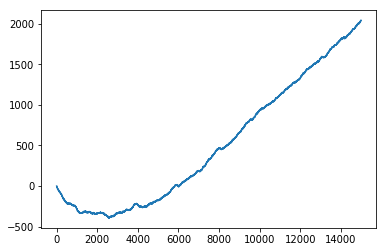

In [181]:
plt.plot(df['reward'])
plt.show()

## TESTING

In [182]:
env = Environment()
state_abs, new_state = env.reset()
final_state = np.array([(1/math.sqrt(2))+0j,(1/math.sqrt(2))+0j])
proj = projection(new_state, final_state)

In [183]:
class ActorCritic(nn.Module):
    def __init__(self, num_inputs, num_outputs, hidden_size, std=0.0):
        super(ActorCritic, self).__init__()
        
        self.critic = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
        
        self.actor = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_outputs),
        )
        self.log_std = nn.Parameter(torch.ones(1, num_outputs) * std)
        
        self.apply(init_weights)
        
    def forward(self, x):

        value = self.critic(x)
        mu    = F.softmax(self.actor(x))
        if(mu.shape[0]==3):
            mu    = mu.reshape(1,mu.shape[0])
        dist  = Categorical(mu)
        return dist, value

In [184]:
num_inputs  = proj.shape[0]
num_outputs = len(command)
hidden_size = 64

In [185]:
# model = torch.load('model_March_6.pth', map_location=torch.device('cpu'))
# model.load_state_dict(torch.load('model_March_6.pth'))
# model
model_2 = ActorCritic(num_inputs, num_outputs, hidden_size)
model_2.load_state_dict(torch.load('model_March_6_2_5_actions.pth'))
model_2.eval()

ActorCritic(
  (critic): Sequential(
    (0): Linear(in_features=1, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
  (actor): Sequential(
    (0): Linear(in_features=1, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=6, bias=True)
  )
)

In [191]:
state_abs, new_state = env.reset()
proj = projection(new_state, final_state)
count=0
while not np.allclose(new_state,final_state):
# while count<5:
    proj = torch.FloatTensor(proj).to(device)
    dist, value = model_2(proj)
    dist = dist.probs
    action= torch.argmax(dist)
    print(command[action].split('(')[0])
    new_state = eval(command[action])
    proj = projection(new_state, final_state)
    count+=1
    print(proj)
    print(count)
#     print(action)
#     count+=1

measurement
[0.5]
1
hadamard_X
[1.]
2


/Users/sarvagya/miniconda3/envs/tifr/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
